# Documentation

**Author:** Spencer Ressel

**Created:** June 14th, 2023

---

This code numerically solves the governing equations from Matsuno (1966). It was mostly written by Daniel Lloveras as a project for the course ATM S 582.  The solver uses the pseudospectral method with leapfrog time differencing to solve the equations of motion.

---

# Imports

In [1]:
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
import sys
import numpy as np
from scipy import special
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.bmh_colors import bmh_colors

# Define physical constants

In [2]:
################# Fundamental Constants ##################
GRAVITY = 9.81                            # g [m/s^2]
EQUIVALENT_DEPTH = 250.                   # H [m]
CORIOLIS_PARAMETER = 2.29e-11             # ß [m^-1 s^-1]
EARTH_RADIUS = 6371.0072e3                # R_e [m]
AIR_DENSITY = 1.225                       # ρ [kg m^-3]
#########################################################


### Conversion factors ###
METERS_PER_DEGREE = 110e3
SECONDS_PER_DAY = 86400
##########################


############################### Derived quantities #################################
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)         # c_g [m s^-1]
time_scale = (CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)   # T [s]
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)  # L [m]
friction_coefficient = 0.0*1/time_scale                              # ε 

print(f"Dry Gravity Wave Phase Speed: {gravity_wave_phase_speed:>10.2f} m/s")
print(f"Time Scale:                   {time_scale*24/SECONDS_PER_DAY:>10.2f} hours")
print(f"Length Scale:                 {length_scale/1e3:>10.2f} km")
####################################################################################

Dry Gravity Wave Phase Speed:      49.52 m/s
Time Scale:                         8.25 hours
Length Scale:                    1470.57 km


# Define simulation parameters

In [21]:
########################### Define simiulaton grid ############################
n_days                   = 30                    # number of days in simulation
n_time_steps             = 2**14                 # number of time steps
meridional_domain_length = 5000e3                # length of half y domain in m
meridional_step_size     = 100e3                 # meridional grid spacing in m
zonal_domain_length      = 2*np.pi*EARTH_RADIUS  # length of x domain in m
zonal_step_size          = 200e3                 # zonal grid spacing in m

simulation_length = n_days*SECONDS_PER_DAY       # simulation length in seconds
time_points = np.linspace(
    0, 
    simulation_length, 
    n_time_steps
)                                                # Array of simulation time points  
time_step = np.diff(time_points)[0]              # Length of a time step in s

meridional_gridpoints = np.arange(                                               
    -meridional_domain_length,
     meridional_domain_length,
     meridional_step_size
)                                                # meridional grid points

zonal_gridpoints = np.arange(                                               
    -zonal_domain_length/2,
     zonal_domain_length/2,
     zonal_step_size 
)                                                # zonal grid points 

nt = len(time_points)                            # number of time steps
ny = len(meridional_gridpoints)                  # number of zonal grid points
nx = len(zonal_gridpoints)                       # number of meridional grid points

# Calculate CFL condition
CFL_x = gravity_wave_phase_speed*time_step/zonal_step_size
CFL_y = gravity_wave_phase_speed*time_step/meridional_step_size

print(f"{'Simulation Parameters':^48}")
print(f"{'':=^48}")
print(
    f"{'Lx =':4}" + 
    f"{zonal_domain_length/1e3:>6.0f}{' km':<6}" + 
    f"{'| Δx = ':>5}" + 
    f"{zonal_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| nx = ':<5}" + 
    f"{nx:>5.0f}"
)
print(
    f"{'Ly =':4}" + 
    f"{2*meridional_domain_length/1e3:>6.0f}" + 
    f"{' km':<6}{'| Δy = ':>5}" + 
    f"{meridional_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| ny = ':<4}" + 
    f"{ny:>5.0f}"
)
print(
    f"{'T  =':4}" + 
    f"{simulation_length/SECONDS_PER_DAY:>6.0f}" + 
    f"{' days':<6}{'| Δt = ':>5}" + 
    f"{time_step:>8.1f}" + 
    f"{' sec':<5}" + 
    f"{'| nt = ':<5}" + 
    f"{nt:>5.0f}"
)
print(f"{'':=^48}")
print(f"CFL_x = {CFL_x:0.3f}", end="")
if (CFL_x < 1/(np.sqrt(2)*np.pi)):
    print(", numerically stable")
else:
    print(", CFL > 1, numerically unstable!!")

    
print(f"CFL_y = {CFL_y:0.3f}", end="")
if (CFL_y < 1/(np.sqrt(2)*np.pi)):
    print(", numerically stable")
    
else:
    print(", CFL > 1, numerically unstable!!")
    
print(f"{'':=^48}")
###########################################################################################

             Simulation Parameters              
Lx = 40030 km   | Δx =    200.0 km  | nx =   201
Ly = 10000 km   | Δy =    100.0 km  | ny =   100
T  =    30 days | Δt =    158.2 sec | nt = 16384
CFL_x = 0.039, numerically stable
CFL_y = 0.078, numerically stable


# Compute solutions

## Initial Conditions

The intial conditions are re-dimensionalized version of Eqs. 17 & 19 from Matsuno (1966).
The meridional structure of the mode is given by parabolic cylinder functions:

*$\psi_{m}(\hat{y}) = e^{-\frac{1}{2}\hat{y}{^2}} \times H_{m}(\hat{y})$*

where $H_{m}(\hat{y})$ is the physicist's Hermite polynomial of order $m$. The horizontal and temporal structure is taken to be wavelike:

$\begin{pmatrix}u \\ v \\ \phi\end{pmatrix}(x, t) = e^{i(kx+\omega t)}$

Where $k$ is the zonal wavenumber and $\omega$ is the frequency, and $t=0$ for the initial condition. As the equations are linear, if the intial state is balanced, the solution will remain balanced for all times. Non-balanced initial conditions will result in high-frequency gravity-waves being generated.

Output file directory: /home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/output/dry-Matsuno/dry-Matsuno_k=1.0_m=1_eps=0.00_Rossby_wave 



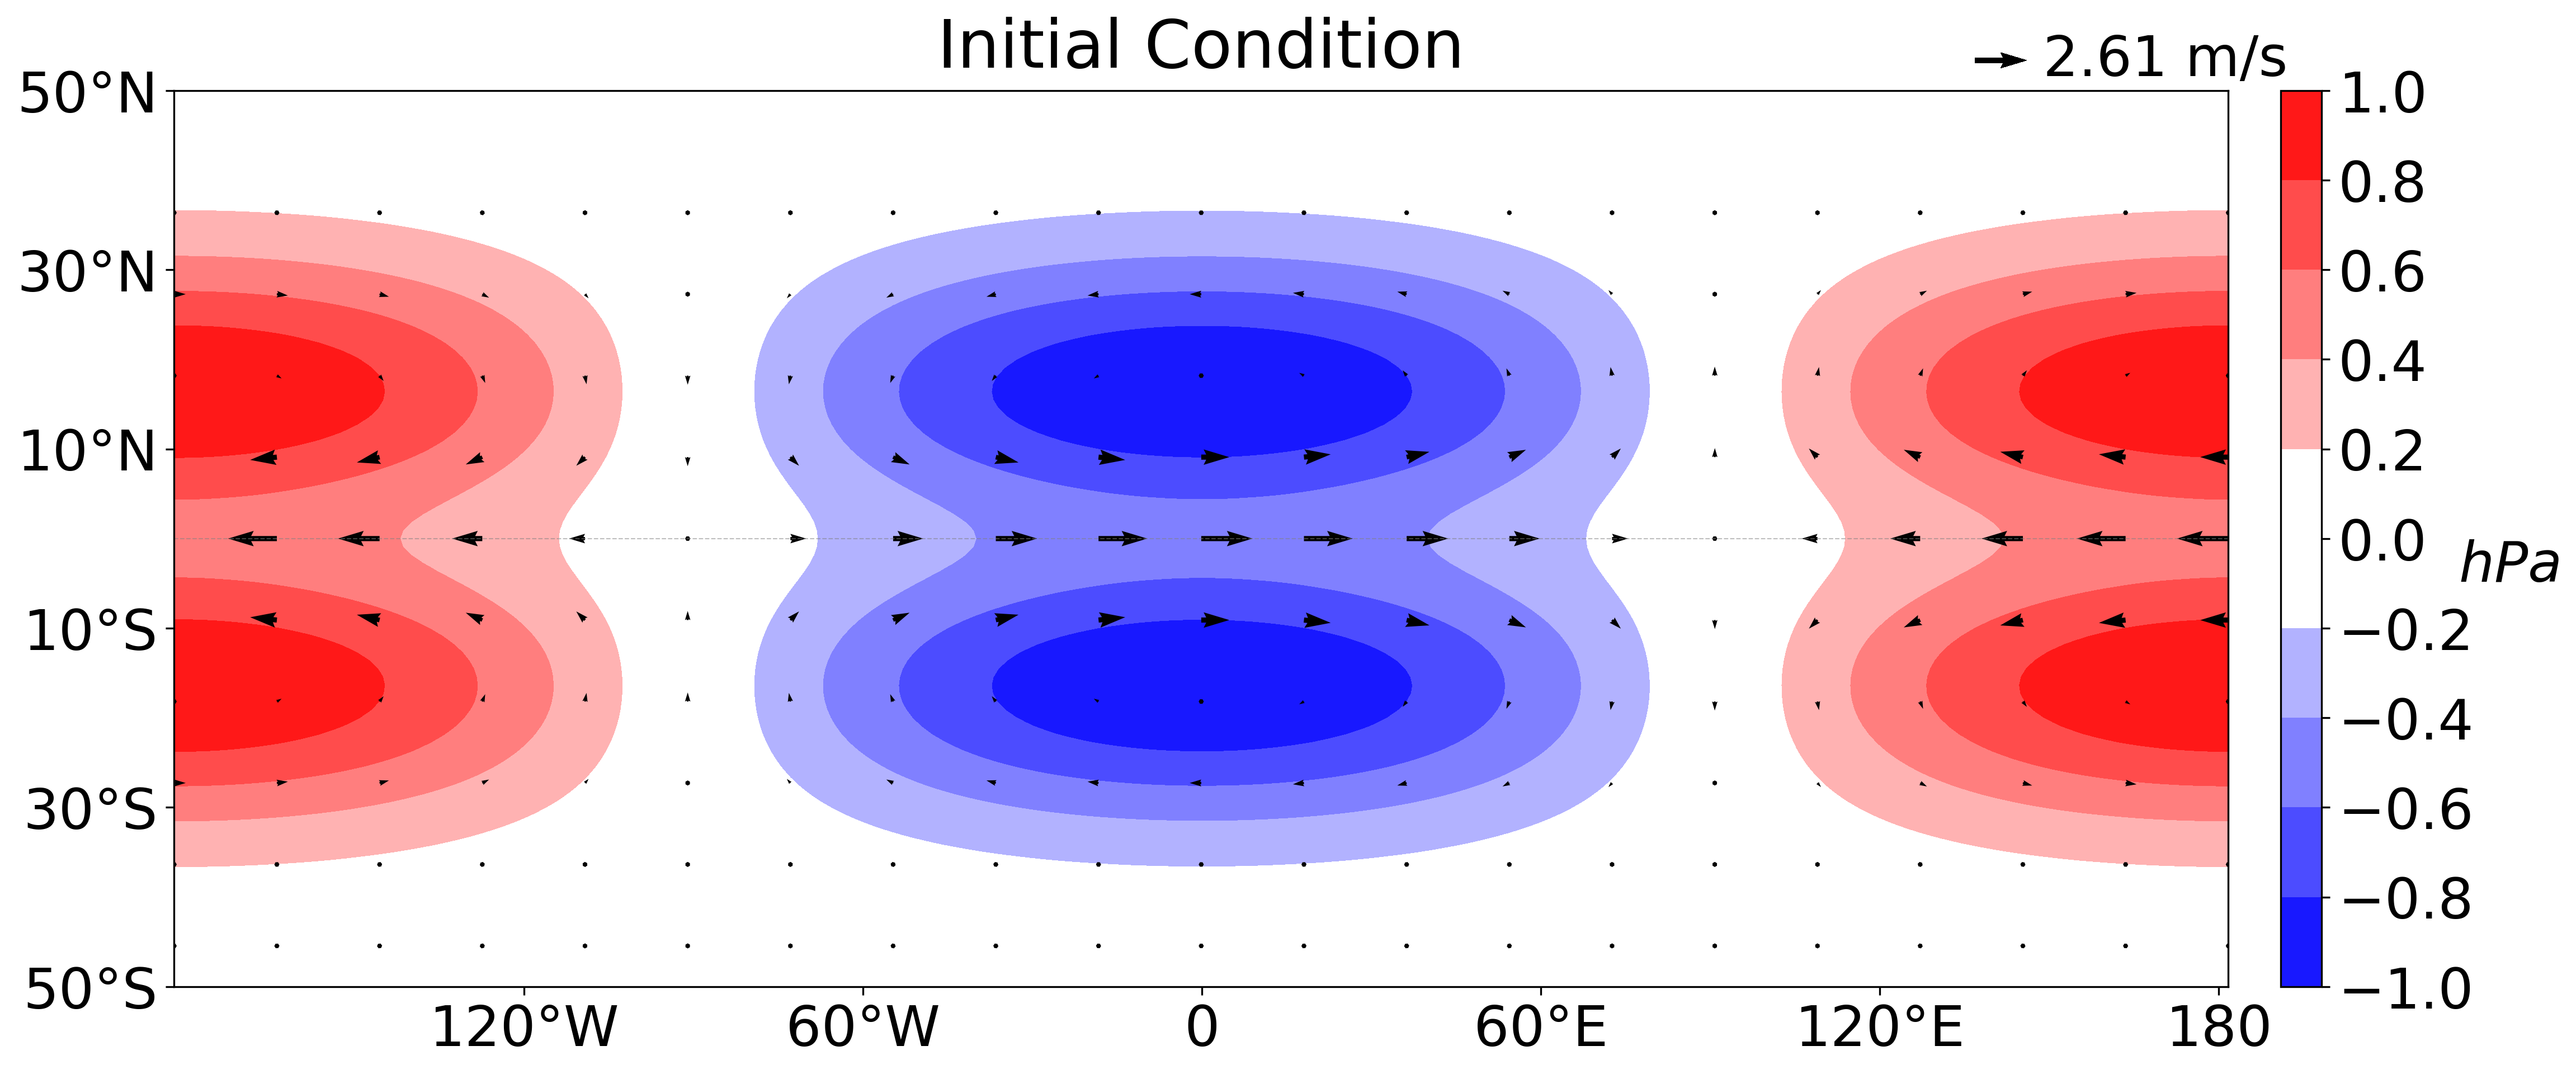

In [23]:
##################################### Define initial condition #####################################
# Initialize arrays
zonal_velocity = np.zeros((nt,ny,nx))
meridional_velocity = np.zeros((nt,ny,nx))
geopotential_height = np.zeros((nt,ny,nx))

# Specify wave parameters
initial_wave = 'Rossby'
initial_geopotential_anomaly = 1*100/AIR_DENSITY # m^2 s^-2
n_wavelengths = 1                                # per Earth circumference
mode_number = 1                                   
initial_wavenumber = 2*np.pi*n_wavelengths/zonal_domain_length

# Calculate wave structure
if initial_wave == 'single-perturbation':
    # Single perturbation
    geopotential_height[0] = gravity_wave_phase_speed*np.einsum(
            'i,j->ij',
            mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
            np.cos(initial_wavenumber*zonal_gridpoints)
    )
    geopotential_height[0, :, np.abs(zonal_gridpoints) > zonal_domain_length/4] = 0
    geopotential_height[geopotential_height < 0] = 0

    
elif initial_wave == 'Kelvin':
    #### Kelvin wave initial condition ####
    # u(x,y,t=0) = c × ψ(y/L, 1) × e^(ikx) [m s^-1]
    zonal_velocity[0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ij',
            mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
            np.exp(1j*initial_wavenumber*zonal_gridpoints)
        )
    )
    
    # ϕ(x,y,t=0) = c^2 × ψ(y/L, 1) × e^(ikx) [m^2 s^-2]
    geopotential_height[0] = gravity_wave_phase_speed**2*np.real(
        np.einsum(
            'i,j->ij',
            mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
            np.exp(1j*initial_wavenumber*zonal_gridpoints)
        )
    )
    
    # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
    zonal_velocity[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    geopotential_height[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    
elif initial_wave == 'Rossby':
    #### Rossby Wave Initial Condition ####
    initial_frequency = (
        CORIOLIS_PARAMETER*initial_wavenumber
        /(initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number+1))
    )
    
    # v(x,y,t=0) = i(1/ß)(ω^2-(ck)^2) × ψ(y/L, m) × e^(ikx) [m s^-1]
    meridional_velocity[0] = np.real(
            np.einsum(
                'i,j->ij',
                (
                    1j*(1/CORIOLIS_PARAMETER)*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
    zonal_velocity[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
            np.einsum(
                'i,j->ij',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number+1)
                    + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number-1)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # ϕ(x,y,t=0) =  cL × (0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m^2 s^-1]
    geopotential_height[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*gravity_wave_phase_speed*np.real(
            np.einsum(
                'i,j->ij',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number+1)
                    - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number-1)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )
    
    # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
    zonal_velocity[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    meridional_velocity[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    geopotential_height[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    
elif initial_wave == 'EIG':
    #### EIG Initial Condition ####
    initial_frequency = -gravity_wave_phase_speed*np.sqrt(
        initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
    )

    # v(x,y,t=0) = i × (1/ß)(ω^2-(ck)^2)ψ(y/L, m) × e^(ikx) [m s^-1]
    meridional_velocity[0] = np.real(
            np.einsum(
                'i,j->ij',
            (
                1j*(1/CORIOLIS_PARAMETER)*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)
                    *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number)
            ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
    zonal_velocity[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
            np.einsum(
                'i,j->ij',
            (
                0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                    *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number+1)
                + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                    *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number-1)
            ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # ϕ(x,y,t=0) = cL × ((0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m^2 s^-2]
    geopotential_height[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*gravity_wave_phase_speed*np.real(
            np.einsum(
                'i,j->ij',
            (
                0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                    *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number+1)
                - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                    *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number-1)
            ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )
    
    
    # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
    zonal_velocity[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    meridional_velocity[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    geopotential_height[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    
elif initial_wave == 'WIG':
    #### WIG Initial Condition ####
    initial_frequency = gravity_wave_phase_speed*np.sqrt(
        initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
    )

    # v(x,y,t=0) = i × (1/ß)(ω^2-(ck)^2)ψ(y/L, m) × e^(ikx) [m s^-1]
    meridional_velocity[0] = np.real(
            np.einsum(
                'i,j->ij',
                (
                    1j*(1/CORIOLIS_PARAMETER)*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
    zonal_velocity[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
            np.einsum(
                'i,j->ij',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number+1)
                    + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number-1)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # ϕ(x,y,t=0) = cL × ((0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m^2 s^-2]
    geopotential_height[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*gravity_wave_phase_speed*np.real(
            np.einsum(
                'i,j->ij',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number+1)
                    - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number-1)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )
    
    # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
    zonal_velocity[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    meridional_velocity[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
    geopotential_height[0] *= initial_geopotential_anomaly/np.max(geopotential_height[0])
#####################################################################################################################

# Initialize a westward basic state everywhere
# zonal_velocity[0] += -1

##################### Specify output file directory #####################
simulation_name = (
    f"dry-Matsuno"
  + f"_k={initial_wavenumber*zonal_domain_length/(2*np.pi)}" 
  + f"_m={mode_number}"
  + f"_eps={time_scale*friction_coefficient:0.2f}"
  + f"_{initial_wave}_wave"
)
output_file_directory = (
    f"output/dry-Matsuno/{simulation_name}"
)
if not os.path.exists(output_file_directory):
    os.mkdir(output_file_directory)
print(f"Output file directory: {os.getcwd()}/{output_file_directory} \n")
#########################################################################


######################################### Plot initial conditions #########################################
# Specify plotting parameters
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
plt.style.use('default')
plt.rcParams.update({'font.size':24})

# Specify quiver spacing
n_quiver_points = 10
zonal_quiver_plot_spacing = int((1/n_quiver_points/2)*zonal_domain_length/zonal_step_size)
meridional_quiver_plot_spacing = int((1/n_quiver_points)*2*meridional_domain_length/meridional_step_size)

# Calculate the equivalent pressure anomaly in hPa
equivalent_pressure = np.copy(geopotential_height)*AIR_DENSITY/100

# contour_scale = int(np.ceil(np.max(geopotential_height[0])))
contour_scale = np.max(equivalent_pressure[0])
quiver_scale = np.max(zonal_velocity[0])
grid_scaling = 1e-6

contour_args = {
    'levels' :  np.linspace(
                    -contour_scale, 
                    contour_scale, 
                    11
                ),
    # # 'levels' :  11,
    'norm'   :  mcolors.CenteredNorm(),
    'cmap'   :  modified_cmap, 
    # 'extend' :  'both'
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.99, bottom=0.1, wspace=0.05)

# Create axes
cbar_ax = fig.add_subplot(gs[-1])
ax = fig.add_subplot(gs[0])

# Title 
ax.set_title('Initial Condition', pad=10)

# Plot geopotential height/pressure anomalies
cont = ax.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    # geopotential_height[0],
    equivalent_pressure[0],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"$hPa$", rotation=0, labelpad=15)

# Plot wind vectors
quiv = ax.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    zonal_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    meridional_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 1.02,          
    U=quiver_scale,          
    label=f'{quiver_scale:0.2f} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line along the equator
ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
latitude_ticks = np.arange(-50, 50+20, 20)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

# Set aspect ratio
ax.set_aspect('auto')

# Save output figure
plt.savefig(f"{output_file_directory}/{simulation_name}_intial-condition.png", bbox_inches='tight')

## Solve

The equations are solved using the leapfrog and pseudo-spectral methods. The spatial derivatives are calculated using the pseudo-spectral method via Fourier transforms, e.g.:

$\frac{du}{dx} = iku$

The temporal derivatives are approximated using the leapfrog method, where $u[t] = F(u[t-2], \, v[t-1], \, \phi[t-1])$. The first time step is solved using the forward Euler method. 

In [138]:
########## Fourier arrays for taking derivatives using the pseudo-spectral method ##########
zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies
############################################################################################

################################## Compute first step using forward Euler method ##################################
# Transform to wavenumber space
zonal_velocity_zonal_fft           = fft(zonal_velocity[0],      axis=1)
meridional_velocity_meridional_fft = fft(meridional_velocity[0], axis=0)
geopotential_height_zonal_fft      = fft(geopotential_height[0], axis=1)
geopotential_height_meridional_fft = fft(geopotential_height[0], axis=0)

# Compute derivatives
zonal_velocity_zonal_derivative_fft           = 1j*zonal_wavenumber[None,:]*zonal_velocity_zonal_fft
meridional_velocity_meridional_derivative_fft = 1j*meridional_wavenumber[:,None]*meridional_velocity_meridional_fft
geopotential_height_zonal_derivative_fft      = 1j*zonal_wavenumber[None,:]*geopotential_height_zonal_fft
geopotential_height_meridional_derivative_fft = 1j*meridional_wavenumber[:,None]*geopotential_height_meridional_fft
    
# Transform back to physical space
zonal_velocity_zonal_derivative           = np.real(ifft(zonal_velocity_zonal_derivative_fft,axis=1))
meridional_velocity_meridional_derivative = np.real(ifft(meridional_velocity_meridional_derivative_fft,axis=0))
geopotential_height_zonal_derivative      = np.real(ifft(geopotential_height_zonal_derivative_fft,axis=1))
geopotential_height_meridional_derivative = np.real(ifft(geopotential_height_meridional_derivative_fft,axis=0))

# Step forward one time step
# u[1] = u[0] - Δt × (-ßyv[0] + dϕ[0]/dx + εu[0])
zonal_velocity[1] = zonal_velocity[0] - time_step*(
    - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
    + geopotential_height_zonal_derivative
    + friction_coefficient*zonal_velocity[0]
)

# v[1] = v[0] - Δt × (ßyu[0] + dϕ[0]/dy + εv[0])
meridional_velocity[1] =  meridional_velocity[0] - time_step*(
    + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[0] 
    + geopotential_height_meridional_derivative
    + friction_coefficient*meridional_velocity[0]
)

# ϕ[1] = ϕ[0] -  Δt × (c^2 × (du[0]/dx + dv[0]/dy) + εϕ[0])
geopotential_height[1] = geopotential_height[0] - time_step*(
    + gravity_wave_phase_speed**2*(zonal_velocity_zonal_derivative + meridional_velocity_meridional_derivative) 
    + friction_coefficient*geopotential_height[0]
)

# Meridional boundary condition
meridional_velocity[1,0] = 0.
meridional_velocity[1,-1] = 0.
########################################################################################################################

#################################### Step forward using leapfrog time-differencing ####################################
for it in tqdm(range(2,nt), position=0, leave=True, ncols=100):
    # Transform to spectral space
    zonal_velocity_zonal_fft           = fft(zonal_velocity[it-1], axis=1)
    meridional_velocity_meridional_fft = fft(meridional_velocity[it-1], axis=0)
    geopotential_height_zonal_fft      = fft(geopotential_height[it-1], axis=1)
    geopotential_height_meridional_fft = fft(geopotential_height[it-1], axis=0)

    # Compute derivatives
    zonal_velocity_zonal_derivative_fft           = 1j*zonal_wavenumber[None,:]*zonal_velocity_zonal_fft
    meridional_velocity_meridional_derivative_fft = 1j*meridional_wavenumber[:,None]*meridional_velocity_meridional_fft
    geopotential_height_zonal_derivative_fft      = 1j*zonal_wavenumber[None,:]*geopotential_height_zonal_fft
    geopotential_height_meridional_derivative_fft = 1j*meridional_wavenumber[:,None]*geopotential_height_meridional_fft

    # Transform back to physical space
    zonal_velocity_zonal_derivative           = np.real(ifft(zonal_velocity_zonal_derivative_fft, axis=1))
    meridional_velocity_meridional_derivative = np.real(ifft(meridional_velocity_meridional_derivative_fft, axis=0))
    geopotential_height_zonal_derivative      = np.real(ifft(geopotential_height_zonal_derivative_fft, axis=1))
    geopotential_height_meridional_derivative = np.real(ifft(geopotential_height_meridional_derivative_fft, axis=0))

    # Step forward with leapfrog scheme
    # u[t] = 1/(1+2εΔt) × (u[t-2] - 2Δt × (-ßyv[t-1] + dϕ[t-1]/dx))
    zonal_velocity[it] = (1/(1+friction_coefficient*2*time_step))*(zonal_velocity[it-2] - 2*time_step*(
            - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
            + geopotential_height_zonal_derivative
        ))
    
    # u[t] = 1/(1+2εΔt) × (v[t-2] - 2Δt × (ßyu[t-1] + dϕ[t-1]/dy))
    meridional_velocity[it] = (1/(1+friction_coefficient*2*time_step))*(meridional_velocity[it-2] - 2*time_step*(
            + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[it-1] 
            + geopotential_height_meridional_derivative
        ))
    
    # ϕ[t] = 1/(1+2εΔt) × (ϕ[t-2] - 2Δt × c^2(du[t-1]/dx + dv[t-1]/dy))
    geopotential_height[it] = (1/(1+friction_coefficient*2*time_step))*(geopotential_height[it-2] - 2*time_step*(
            + gravity_wave_phase_speed**2*(zonal_velocity_zonal_derivative + meridional_velocity_meridional_derivative) 
        ))
    
    # Meridional boundary condition    
    meridional_velocity[it,0] = 0.
    meridional_velocity[it,-1] = 0.

100%|████████████████████████████████████████████████████████| 16382/16382 [01:37<00:00, 168.39it/s]


# Simulation Output

## Plot solutions

### Horizontal Structure

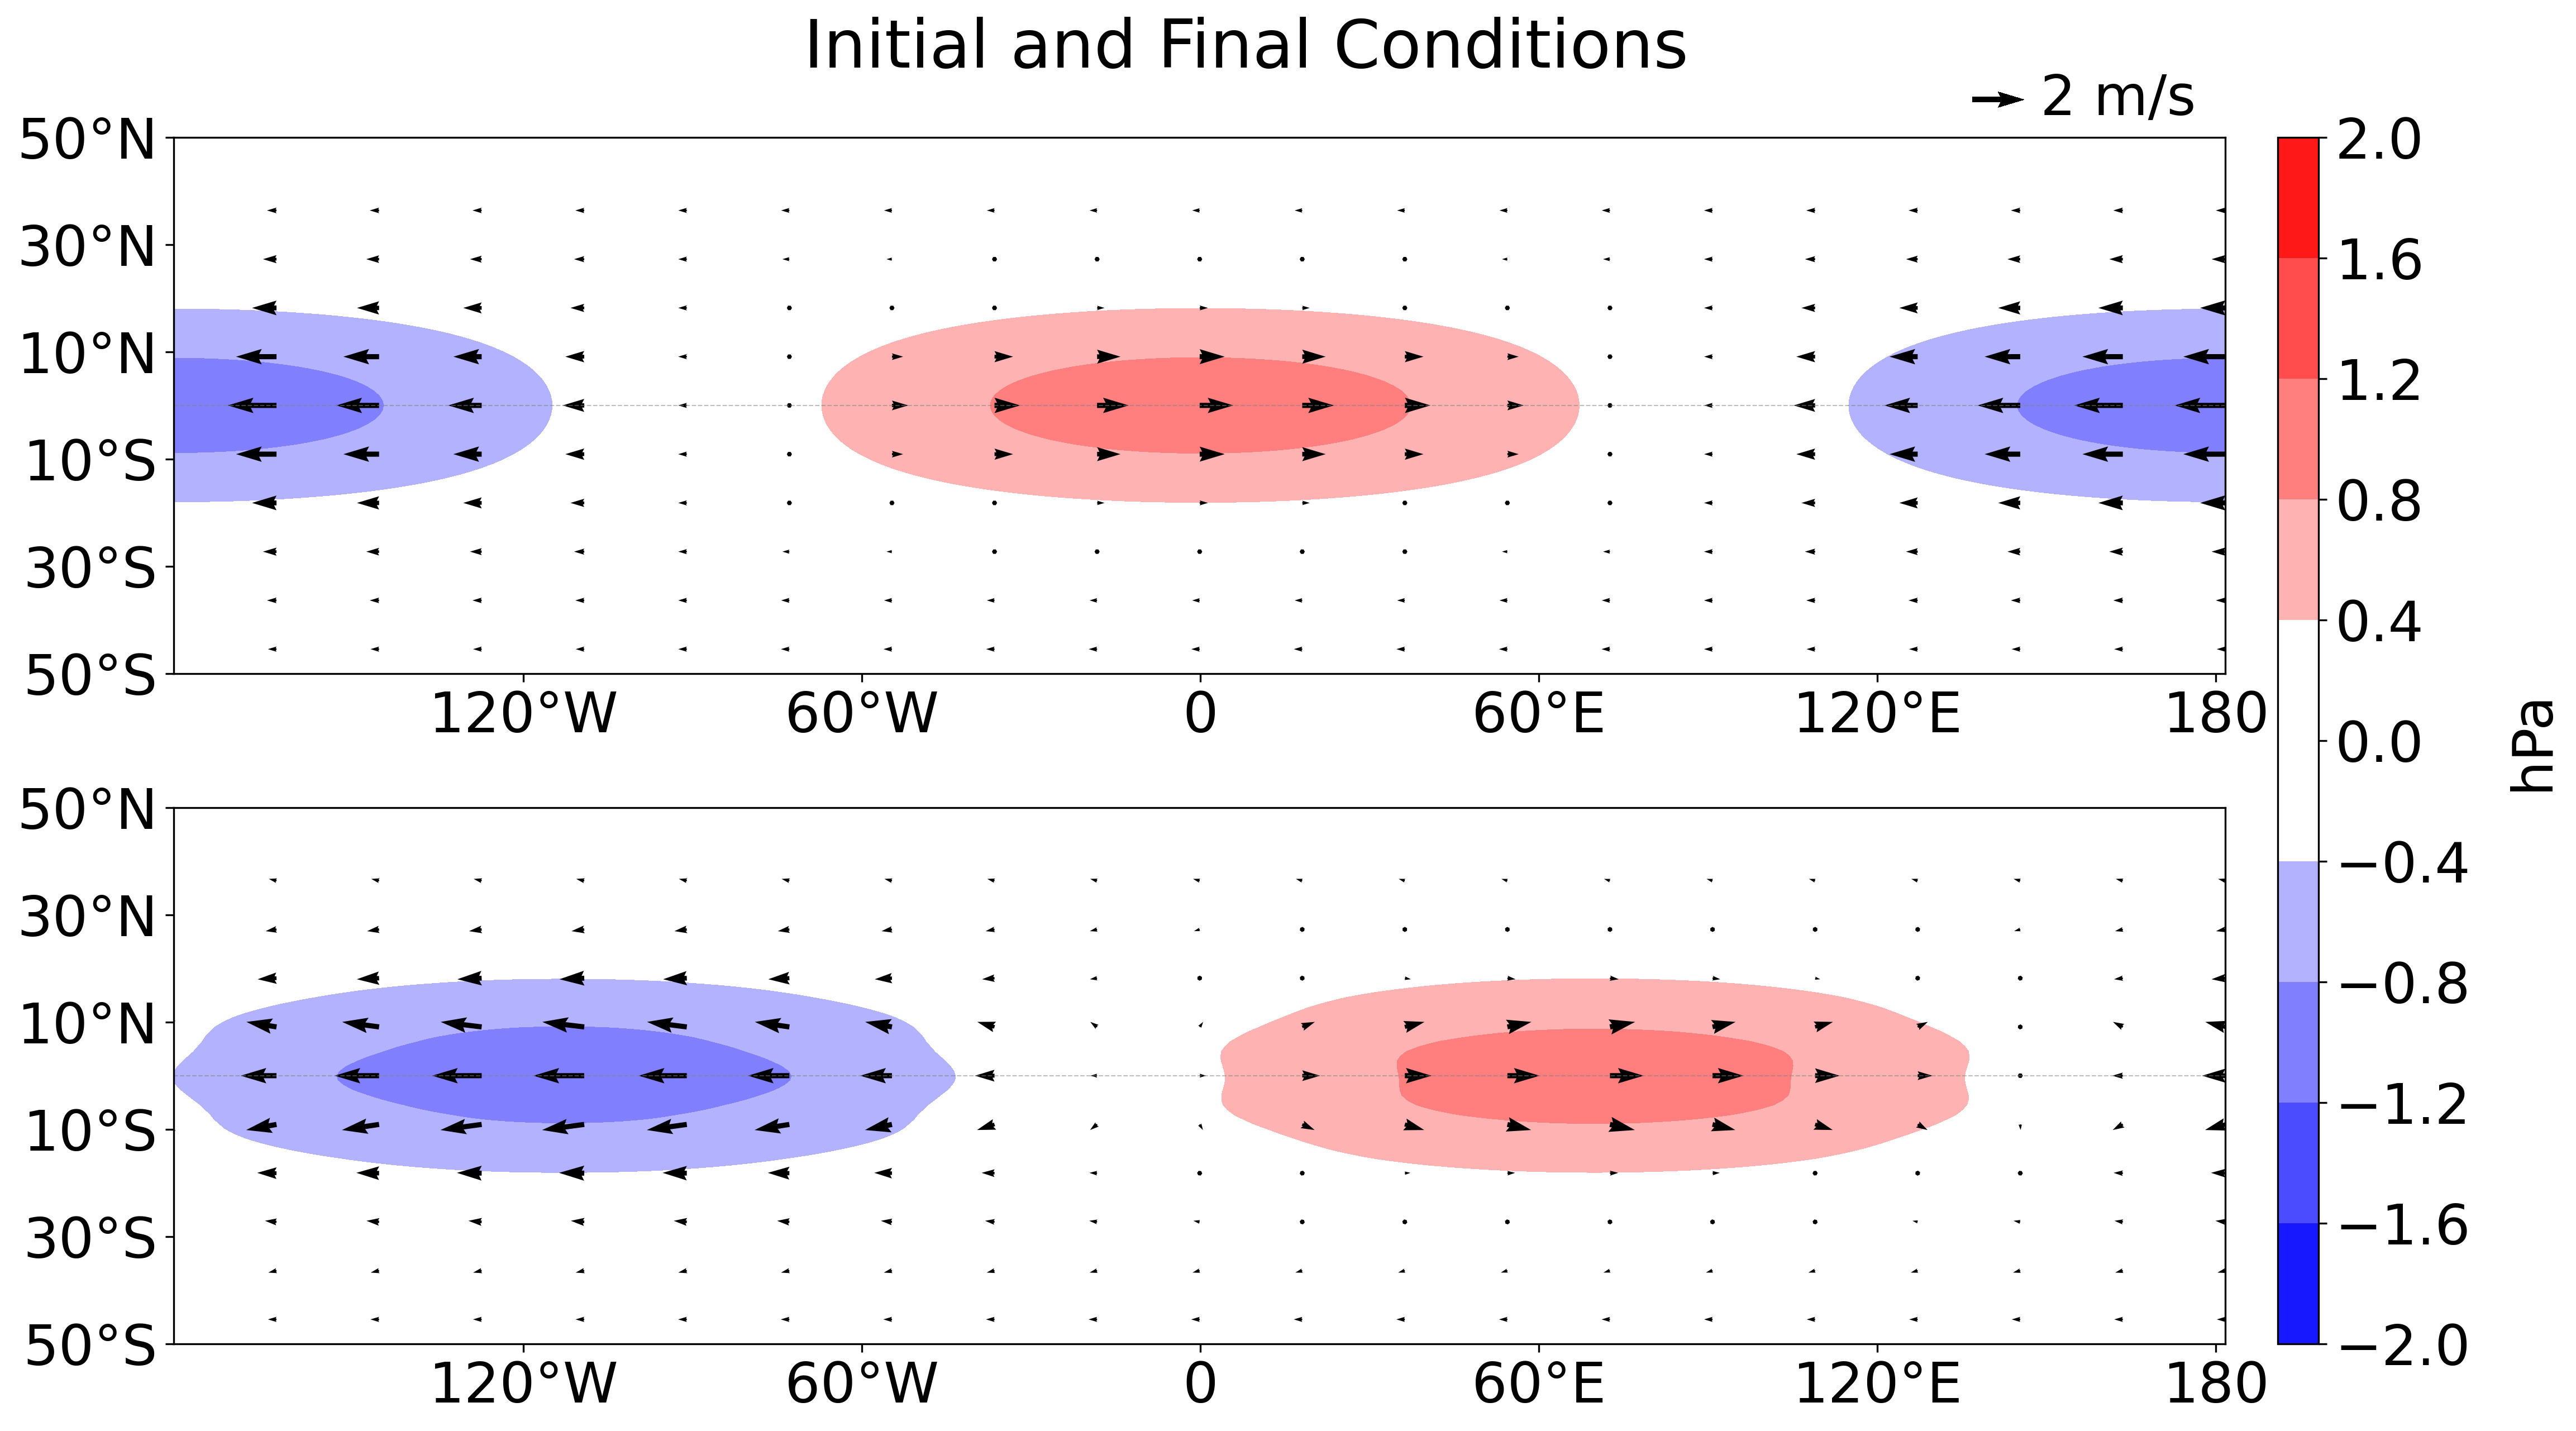

In [139]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

# Calculate the equivalent pressure perturbation in hPa
equivalent_pressure = np.copy(geopotential_height)*AIR_DENSITY/100
# contour_scale = int(np.ceil(np.max(geopotential_height)))
contour_scale = int(np.ceil(np.max(equivalent_pressure)))
quiver_scale = int(np.ceil(np.max(zonal_velocity)))
grid_scaling = 1e-6

end_frame = -10

contour_args = {
    # 'levels' : np.arange(
    #                -np.around(gravity_wave_phase_speed, 0), 
    #                np.around(gravity_wave_phase_speed, 0)+10, 
    #                10
    #            ),
    'levels' : np.linspace(-contour_scale, contour_scale, 11),
    # 'levels' : 11, 
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    # 'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,9),dpi=300)
gs = GridSpec(2, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

# Label figure
fig.suptitle('Initial and Final Conditions')

#### Initial Condition ####
# Add for the initial condition
cbar_ax = fig.add_subplot(gs[:, -1])
ax0 = fig.add_subplot(gs[0, 0])

# Plot contours of geopotential height anomalies
cont = ax0.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    # geopotential_height[0],
    equivalent_pressure[0],
    **contour_args
)

cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"hPa", labelpad=15)

# Plot vectors of wind anomalies
quiv = ax0.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    zonal_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    meridional_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

# Add a key for the wind vectors
ax0.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line on the equator
ax0.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label y axis
# ax0.set_ylabel(r" y (10$^{3}$ km)")

# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax0.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

latitude_ticks = np.arange(-50, 50+20, 20)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax0.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

# Set the plot aspect
ax0.set_aspect('auto')
#########################

#### Final Condition ####
# Add axes for final condition
ax1 = fig.add_subplot(gs[1, 0])

# Geopotential Height contours
cont1 = ax1.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    # geopotential_height[end_frame],
    equivalent_pressure[end_frame],
    **contour_args
)

# Wind vectors
quiv1 = ax1.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    zonal_velocity[end_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    meridional_velocity[end_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

# Equator line
ax1.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label axes
# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax1.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

latitude_ticks = np.arange(-50, 50+20, 20)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax1.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)


# ax1.set_xlabel(r" x (10$^{3}$ km)")
# ax1.set_ylabel(r" y (10$^{3}$ km)")

# Aspect ratio
ax1.set_aspect('auto')

plt.savefig(f"{output_file_directory}/{simulation_name}_horizontal-structure.png", bbox_inches='tight')

### Temporal Structure

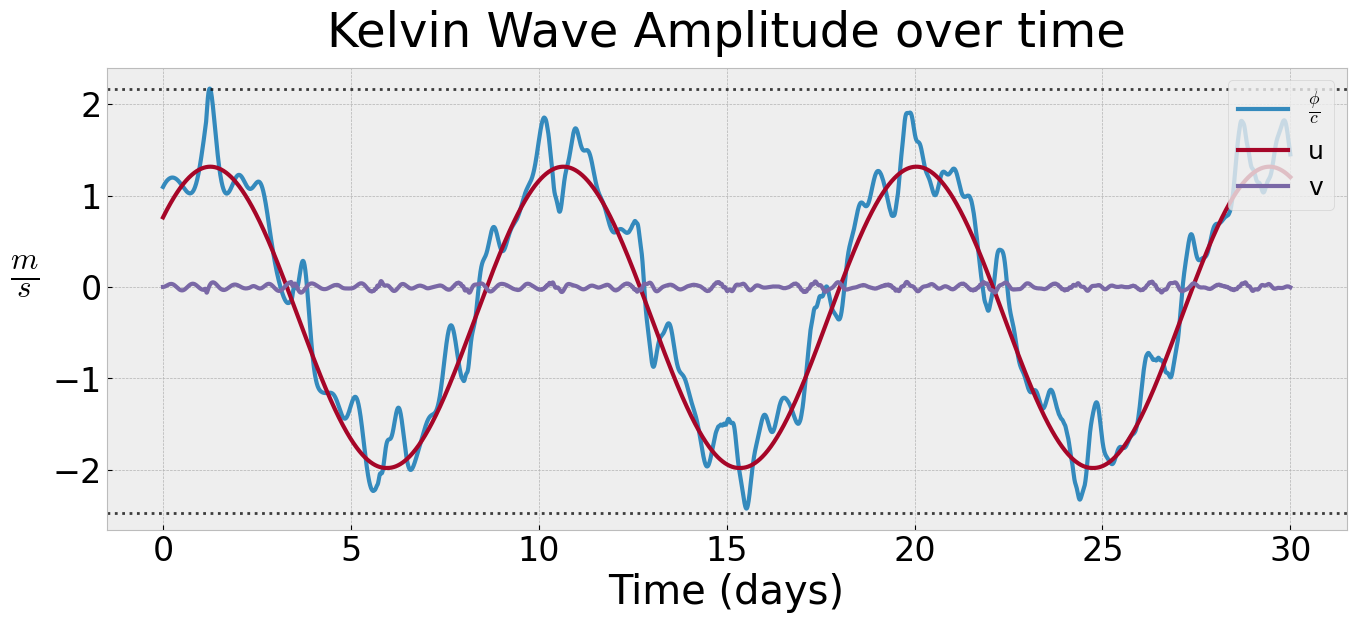

In [140]:
# Specify plotting parameters
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

# Find the location of the maximum geopotential height anomaly
max_index = np.argmax(geopotential_height)
[t_index, y_index, x_index] = np.unravel_index(max_index, [nt, ny, nx])

# Create plot
[fig, ax] = plt.subplots(figsize=(16,6))
ax.set_title(f"{initial_wave} Wave Amplitude over time", pad=15)

# Plot scaled geopotential height over time
ax.plot(
    time_points/SECONDS_PER_DAY, 
    geopotential_height[:, y_index, x_index]/gravity_wave_phase_speed, 
    lw=3, 
    label=r"$\frac{\phi}{c}$"
)

# Plot zonal velocity over time
ax.plot(
    time_points/SECONDS_PER_DAY, 
    zonal_velocity[:, y_index, x_index], 
    lw=3, 
    label='u'
)

# Plot meridional velocity over time
ax.plot(
    time_points/SECONDS_PER_DAY, 
    meridional_velocity[:, y_index, x_index], 
    lw=3, 
    label='v'
)

# Plot a line at the maximum scaled geopotential height value
ax.axhline(
    y=np.max(geopotential_height)/gravity_wave_phase_speed,
    color='black',
    ls=':',
    alpha=0.75
)

# Plot a line at the minimum scaled geopotential height value
ax.axhline(
    y=np.min(geopotential_height)/gravity_wave_phase_speed,
    color='black',
    ls=':',
    alpha=0.75
)

# Label the plot and axes
ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{m}{s}$", rotation=0, labelpad=20, fontsize=32)
ax.legend(loc='upper right', fontsize=18)

# Save the figure
plt.savefig(f"{output_file_directory}/{simulation_name}_temporal-structure.png", bbox_inches='tight')

### Animate solutions

 98%|█████████████████████████████████████████████████████████████▋ | 49/50 [00:46<00:01,  1.44s/it]

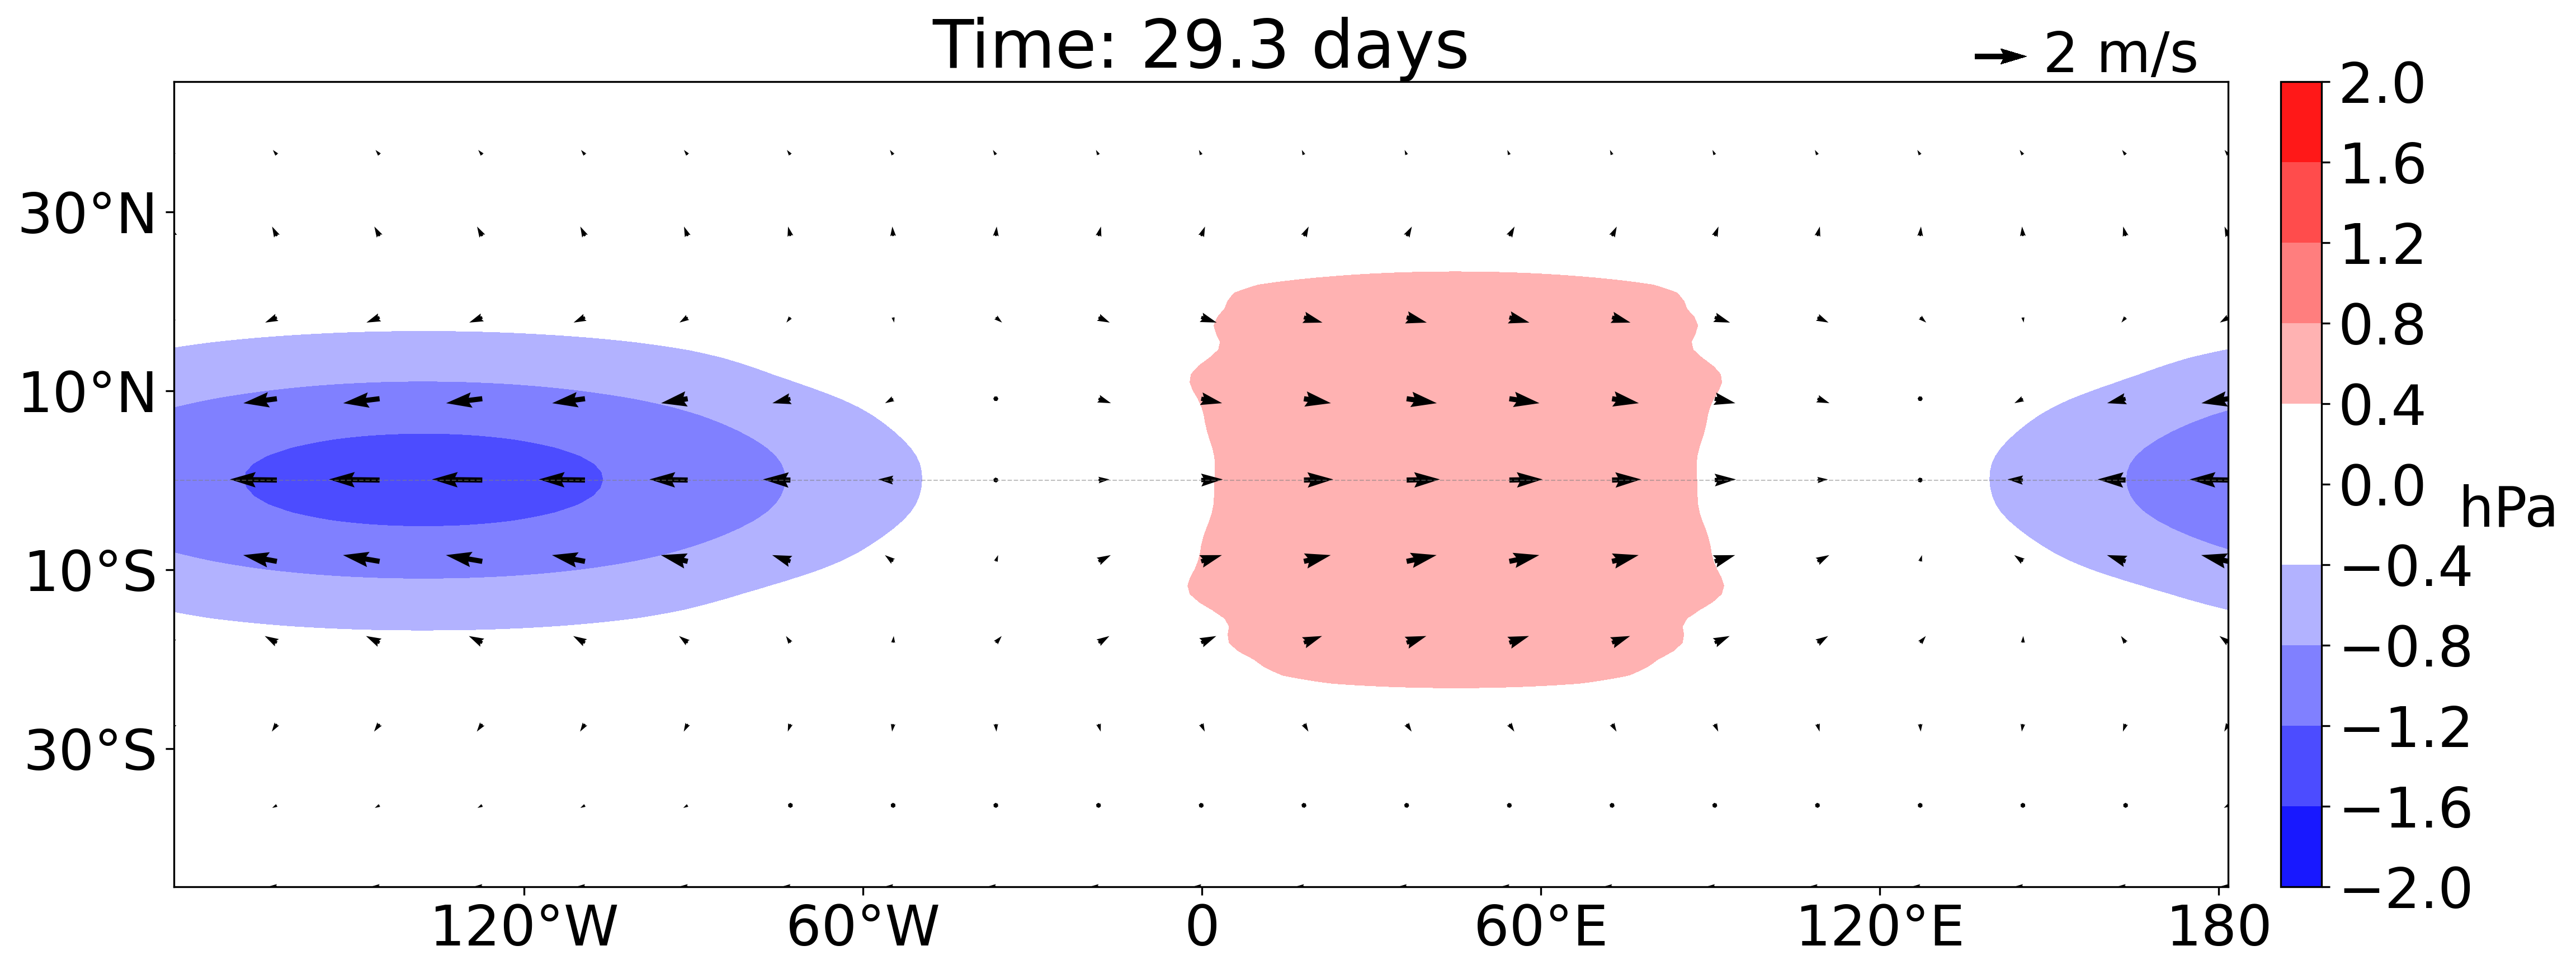

In [141]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})

# Specify animation parameters
n_frames = 50
starting_frame = 0
frame_interval = int((nt - starting_frame)/n_frames)
# frame_interval = 2
end_frame = starting_frame + n_frames*frame_interval
frames = np.arange(starting_frame, end_frame, frame_interval)

# Calculate equivalent pressure anomaly in hPa
equivalent_pressure = np.copy(geopotential_height)*AIR_DENSITY/100

contour_scale = int(np.ceil(np.max(equivalent_pressure)))
# contour_scale = int(np.ceil(np.max(geopotential_height)))
quiver_scale = int(np.ceil(np.max(zonal_velocity)))
grid_scaling = 1e-6

contour_args = {
    'levels' : np.linspace(-contour_scale, contour_scale, 11),
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    # 'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

# Create axes
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

# Title
ax.set_title(f"Time: {time_points[starting_frame]/SECONDS_PER_DAY:0.1f} days")

# Plot geopotential/pressure anomalies
cont = ax.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    # geopotential_height[starting_frame],
    equivalent_pressure[starting_frame],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"hPa", rotation=0, labelpad=15)                    

# Plot wind vectors
quiv = ax.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    zonal_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    meridional_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot line at the equator
ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

latitude_ticks = np.arange(-50, 50+20, 20)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

ax.set_aspect('auto')

def update(current_frame):
    
    # plotting_index = starting_frame + frame_interval*current_frame
    plotting_index = current_frame
    
    ax.set_title(f"Time: {time_points[plotting_index]/SECONDS_PER_DAY:0.1f} days")
    cont = ax.contourf(
        zonal_gridpoints*grid_scaling,
        meridional_gridpoints*grid_scaling,
        # geopotential_height[plotting_index],
        equivalent_pressure[plotting_index],
        **contour_args
    )
    quiv = ax.quiver(
        zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
        meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
        zonal_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        meridional_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        **quiver_args
    )
    return cont, quiv
    
# Create animation
anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

# Save animation
anim.save(f"{output_file_directory}/{simulation_name}_animation.mp4", dpi=300)

## Filter Solutions

In [151]:
# Specify which wave type to plot
filtered_wave = 'Rossby'

# Filter period in days
filter_period = 5*SECONDS_PER_DAY

if filtered_wave == 'Kelvin' or filtered_wave == 'Rossby':
    time_filtered_zonal_velocity = mjo.butter_lowpass_filter(zonal_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_meridional_velocity = mjo.butter_lowpass_filter(meridional_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_geopotential_height = mjo.butter_lowpass_filter(geopotential_height.T, 1/filter_period, 1/time_step).T
    
elif filtered_wave == 'EIG' or filtered_wave == 'WIG':
    time_filtered_zonal_velocity = mjo.butter_highpass_filter(zonal_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_meridional_velocity = mjo.butter_highpass_filter(meridional_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_geopotential_height = mjo.butter_highpass_filter(geopotential_height.T, 1/filter_period, 1/time_step).T

print("Time Filtering Complete")
print("=======================")
# frequencies = np.fft.fftfreq(nt, time_step)
# phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(meridional_gridpoints), axis=1)

# # Depending on the wave type specified, filter out waves propagating in the wrong direction
# if filtered_wave == 'Kelvin' or filtered_wave == 'EIG':
#     filter_condition = np.where(zonal_wavenumber != (2*np.pi)/zonal_domain_length)
#     # filter_condition = np.where(phase_speed <= 0)
    
# elif filtered_wave == 'Rossby' or filtered_wave == 'WIG':
#     filter_condition = np.where(phase_speed >= 0)
    
# zonal_velocity_fft = np.fft.fft2(time_filtered_zonal_velocity, axes=[0,2])
# zonal_velocity_fft[filter_condition] = 0+1j*0
# zonal_velocity_filtered = np.real(np.fft.ifft2(zonal_velocity_fft, axes=[0,2]))

# meridional_velocity_fft = np.fft.fft2(time_filtered_meridional_velocity, axes=[0,2])
# meridional_velocity_fft[filter_condition] = 0+1j*0
# meridional_velocity_filtered = np.real(np.fft.ifft2(meridional_velocity_fft, axes=[0,2]))

# geopotential_height_fft = np.fft.fft2(time_filtered_geopotential_height, axes=[0,2])
# geopotential_height_fft[filter_condition] = 0+1j*0
# geopotential_height_filtered = np.real(np.fft.ifft2(geopotential_height_fft, axes=[0,2]))

# print("Direction Filtering Complete")
# print("============================")

Time Filtering Complete


### Plot filtered solutions

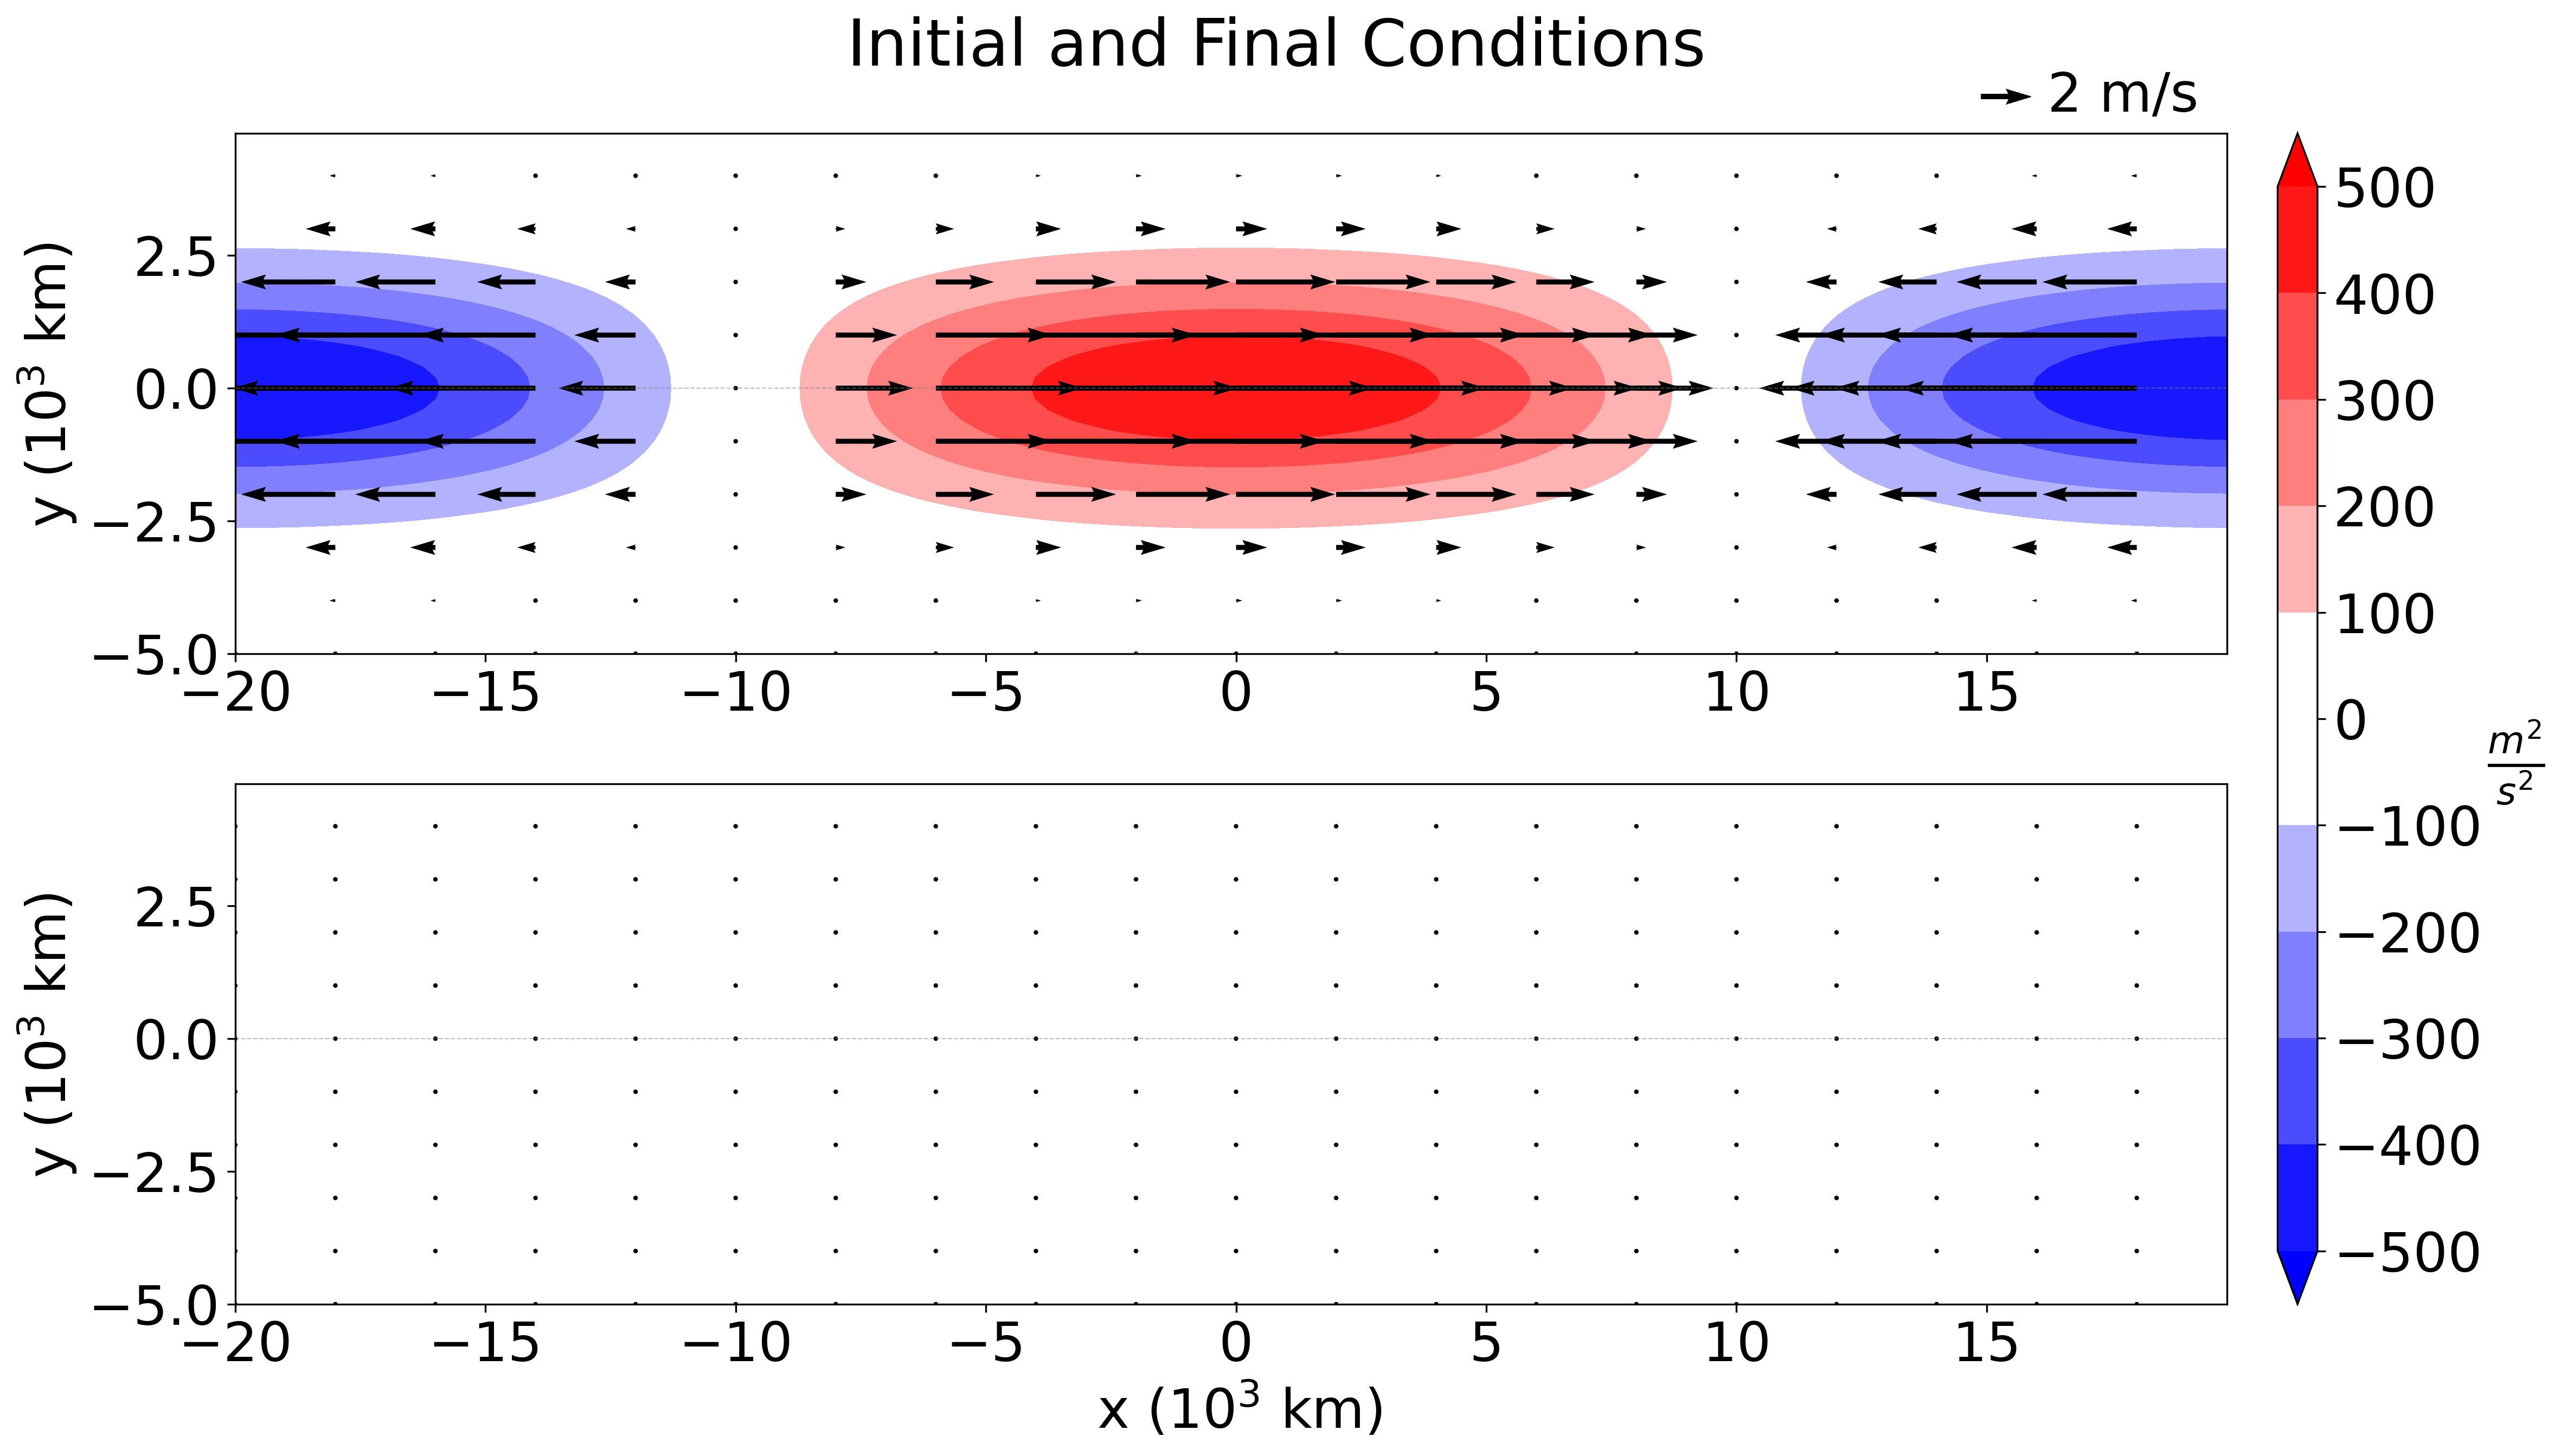

In [90]:
geopotential_height_filtered = time_filtered_geopotential_height
zonal_velocity_filtered = time_filtered_zonal_velocity
meridional_velocity_filtered = time_filtered_meridional_velocity

# Specify plotting parameters
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
grid_scaling = 1e-6
quiver_scale = int(np.ceil(np.max(zonal_velocity_filtered)))
end_frame = -1

contour_args = {
    # 'levels':np.linspace(-50,50,11),
    'levels' : np.linspace(np.min(geopotential_height), np.max(geopotential_height), 11),
    'norm':mcolors.CenteredNorm(),
    'cmap':modified_cmap, 
    'extend':'both'    
}

quiver_args = {
    'color':'k',
    'width':0.0025,
    'angles':'xy',
    'scale_units':'xy',
    'scale':quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,9),dpi=300)
gs = GridSpec(2, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

# Label figure
fig.suptitle('Initial and Final Conditions')

#### Initial Condition ####
# Add for the initial condition
cbar_ax = fig.add_subplot(gs[:, -1])
ax0 = fig.add_subplot(gs[0, 0])

# Plot contours of geopotential height anomalies
cont = ax0.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    geopotential_height[0],
    **contour_args

)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)

# Plot vectors of wind anomalies
quiv = ax0.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    zonal_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    meridional_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

# Add a key for the wind vectors
ax0.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line on the equator
ax0.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label y axis
ax0.set_ylabel(r" y (10$^{3}$ km)")

# Set the plot aspect
ax0.set_aspect('auto')
#########################

#### Final Condition ####
# Add axes for final condition
ax1 = fig.add_subplot(gs[1, 0])

# Geopotential Height contours
cont1 = ax1.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    geopotential_height_filtered[end_frame],
    **contour_args
)

# Wind vectors
quiv1 = ax1.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    zonal_velocity_filtered[end_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    meridional_velocity_filtered[end_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

# Equator line
ax1.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label axes
ax1.set_xlabel(r" x (10$^{3}$ km)")
ax1.set_ylabel(r" y (10$^{3}$ km)")

# Aspect ratio
ax1.set_aspect('auto')

#### Time Filtered Solution

In [351]:
filter_type = 'high-pass'
filter_period = 3*SECONDS_PER_DAY

if filter_type == 'high-pass':
    time_filtered_zonal_velocity = mjo.butter_highpass_filter(zonal_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_meridional_velocity = mjo.butter_highpass_filter(meridional_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_geopotential_height = mjo.butter_highpass_filter(geopotential_height.T, 1/filter_period, 1/time_step).T
    
elif filter_type == 'low-pass':
    time_filtered_zonal_velocity = mjo.butter_lowpass_filter(zonal_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_meridional_velocity = mjo.butter_lowpass_filter(meridional_velocity.T, 1/filter_period, 1/time_step).T
    time_filtered_geopotential_height = mjo.butter_lowpass_filter(geopotential_height.T, 1/filter_period, 1/time_step).T

##### Horizontal Structure

TypeError: Length of x (201) must match number of columns in z (200)

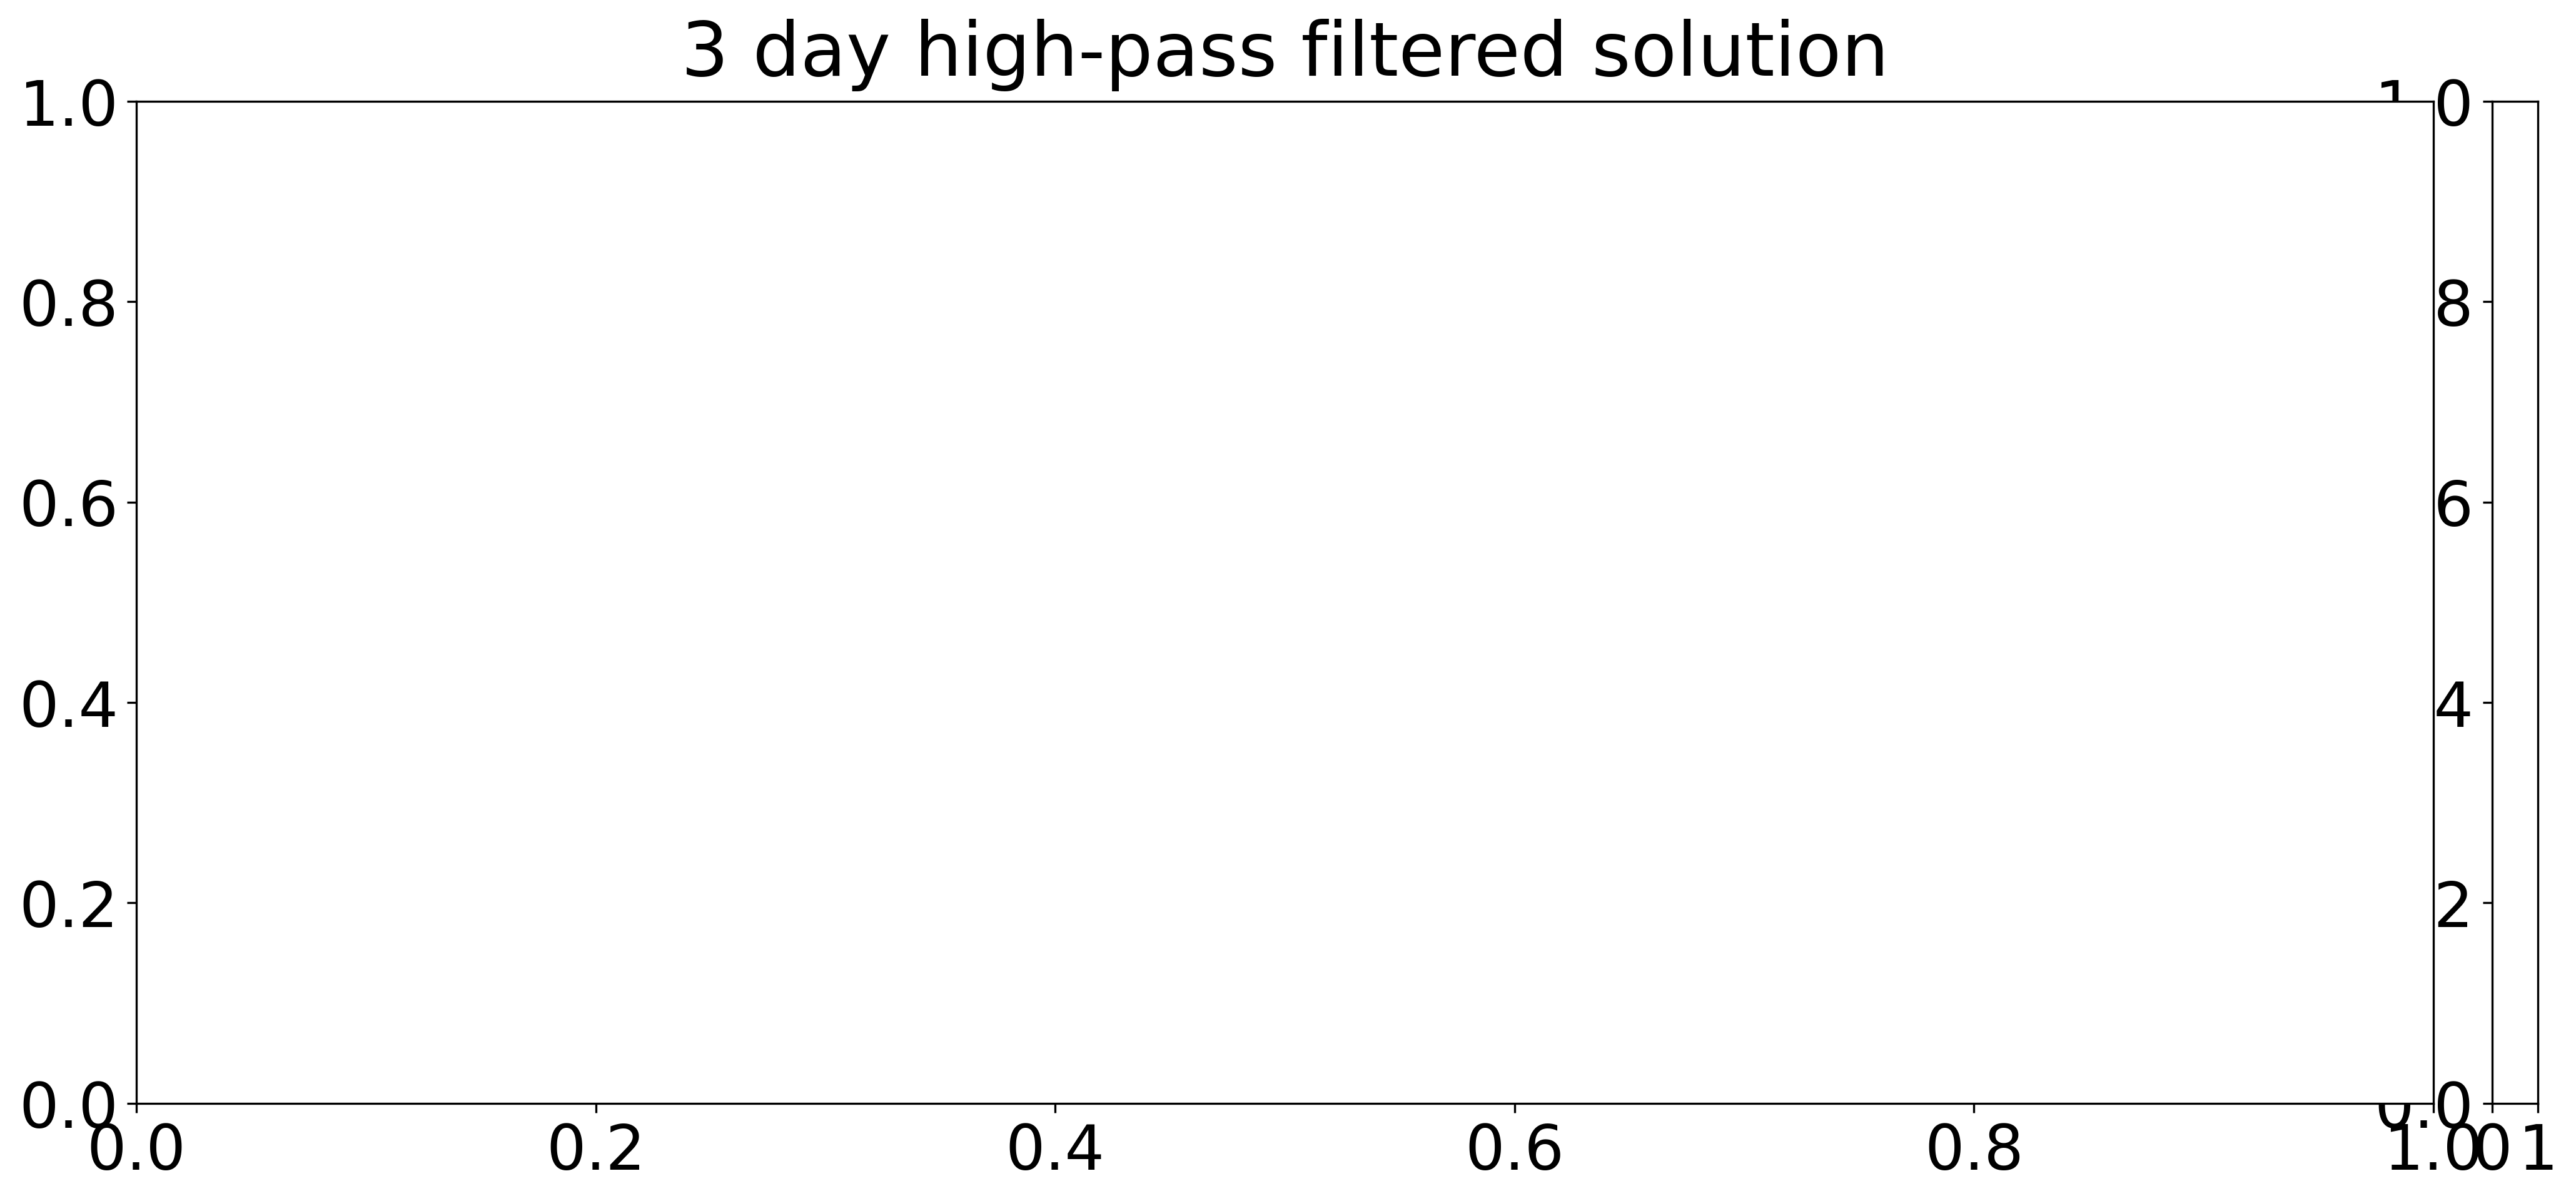

In [567]:
#### Plot initial conditions ####
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
plt.style.use('default')
plt.rcParams.update({'font.size':24})

# Calculate the equivalent pressure anomaly in hPa
time_filtered_equivalent_pressure = np.copy(time_filtered_geopotential_height)*AIR_DENSITY/100

frame = -1000

# contour_scale = int(np.ceil(np.max(geopotential_height[0])))
contour_scale = int(np.ceil(np.max(time_filtered_equivalent_pressure[frame])))
quiver_scale = int(np.ceil(np.max(time_filtered_zonal_velocity[frame])))
# quiver_scale = 500
grid_scaling = 1e-6

contour_args = {
    # 'levels' :  np.linspace(
    #                 -contour_scale, 
    #                 contour_scale, 
    #                 11
    #             ),
    'levels' :  11,
    'norm'   :  mcolors.CenteredNorm(),
    'cmap'   :  modified_cmap, 
    # 'extend' :  'both'
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.99, bottom=0.1, wspace=0.05)

cbar_ax = fig.add_subplot(gs[-1])
ax = fig.add_subplot(gs[0])

ax.set_title(f"{filter_period/SECONDS_PER_DAY:0.0f} day {filter_type} filtered solution", pad=10)

cont = ax.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    # geopotential_height[0],
    time_filtered_equivalent_pressure[frame],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
# cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"$hPa$", rotation=0, labelpad=15)

quiv = ax.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    time_filtered_zonal_velocity[frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    time_filtered_meridional_velocity[frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 1.02,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.set_xlabel(r"x (10$^{3}$ km)")
ax.set_ylabel(r"y (10$^{3}$ km)")

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

ax.set_aspect('auto')
# ax.grid()

##### Temporal Structure

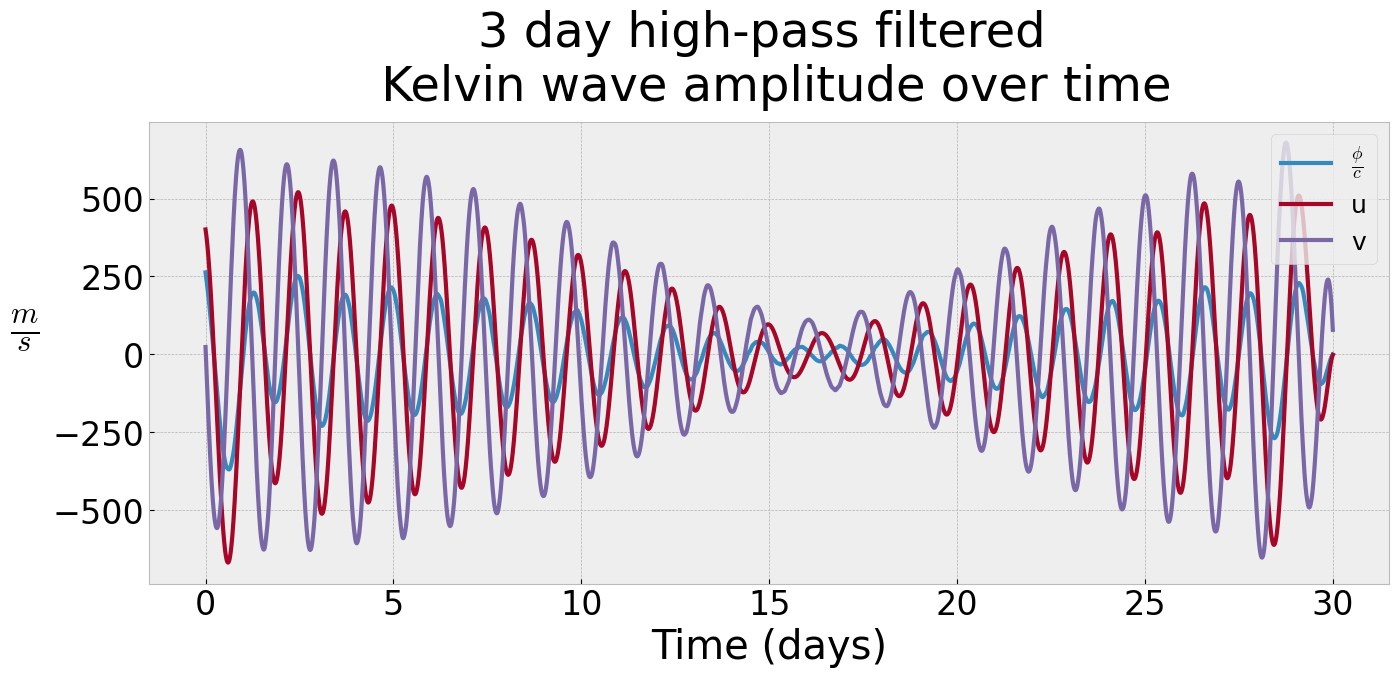

In [358]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

x_index = np.argmax(time_filtered_geopotential_height[0,0])
y_index = np.argmax(time_filtered_geopotential_height[0,:,x_index])

[fig, ax] = plt.subplots(figsize=(16,6))
ax.set_title(f"{filter_period/SECONDS_PER_DAY:0.0f} day {filter_type} filtered \n {initial_wave} wave amplitude over time", pad=15)

ax.plot(
    time_points/SECONDS_PER_DAY, 
    time_filtered_geopotential_height[:, y_index, x_index]/gravity_wave_phase_speed, 
    lw=3, 
    label=r"$\frac{\phi}{c}$"
)

ax.plot(
    time_points/SECONDS_PER_DAY, 
    time_filtered_zonal_velocity[:, y_index, x_index], 
    lw=3, 
    label='u'
)

ax.plot(
    time_points/SECONDS_PER_DAY, 
    time_filtered_meridional_velocity[:, y_index, x_index], 
    lw=3, 
    label='v'
)

ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{m}{s}$", rotation=0, labelpad=20, fontsize=32)

ax.legend(loc='upper right', fontsize=18)

plt.show()

#### Animate filtered solutions

 98%|█████████████████████████████████████████████████████████████▊ | 50/51 [00:44<00:01,  1.36s/it]

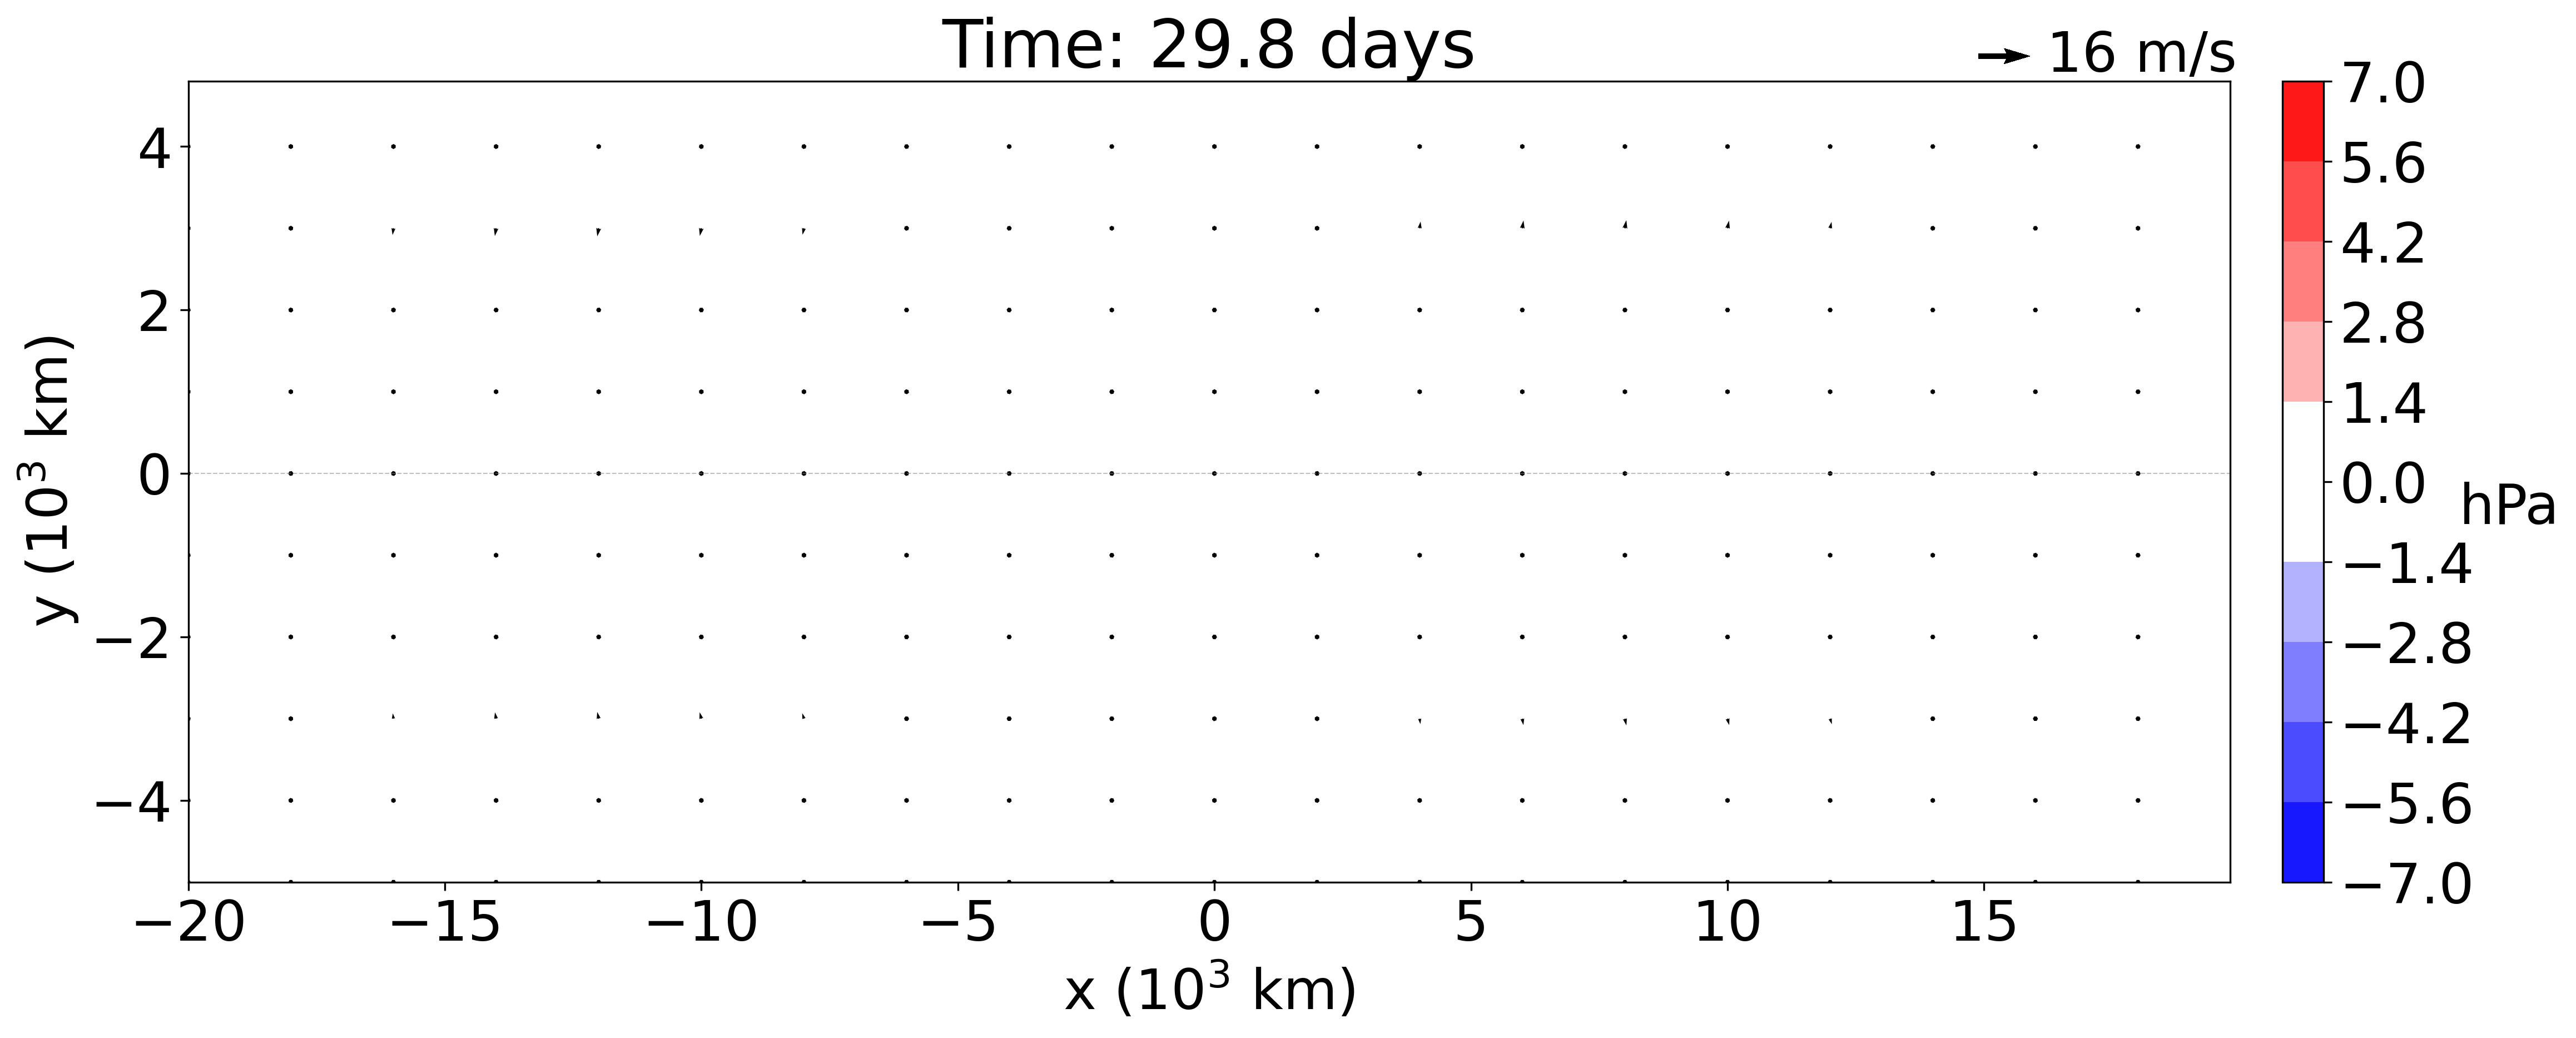

In [187]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})

n_frames = 50
starting_frame = 0
frame_interval = int((nt - starting_frame)/n_frames)
frames = np.arange(starting_frame, nt, frame_interval)

# Calculate equivalent pressure anomaly in hPa
equivalent_pressure = np.copy(geopotential_height)*AIR_DENSITY/100

contour_scale = int(np.ceil(np.max(equivalent_pressure)))
# contour_scale = int(np.ceil(np.max(geopotential_height)))
quiver_scale = int(np.ceil(np.max(zonal_velocity)))
grid_scaling = 1e-6

contour_args = {
    'levels' : np.linspace(-contour_scale, contour_scale, 11),
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    # 'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time_points[starting_frame]/SECONDS_PER_DAY:0.1f} days")

cont = ax.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    # geopotential_height[starting_frame],
    time_filtered_equivalent_pressure[starting_frame],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'])
# cbar.set_label(r"$\frac{m^2}{s^2}$", rotation=0, labelpad=15)
cbar.set_label(r"hPa", rotation=0, labelpad=15)                    

quiv = ax.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    time_filtered_zonal_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    time_filtered_meridional_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('auto')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

def update(current_frame):
    
    # plotting_index = starting_frame + frame_interval*current_frame
    plotting_index = current_frame
    
    ax.set_title(f"Time: {time_points[plotting_index]/SECONDS_PER_DAY:0.1f} days")
    cont = ax.contourf(
        zonal_gridpoints*grid_scaling,
        meridional_gridpoints*grid_scaling,
        # geopotential_height[plotting_index],
        time_filtered_equivalent_pressure[plotting_index],
        **contour_args
    )
    quiv = ax.quiver(
        zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
        meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
        time_filtered_zonal_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        time_filtered_meridional_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        **quiver_args
    )
    return cont, quiv
    
anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

anim_dir = (
    r"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/numerical_solver_output/dry-Matsuno/"
)
anim_file_name = (
    "dry-Matsuno" 
    + f"_k={initial_wavenumber*zonal_domain_length}" 
    + f"_m={mode_number}" 
    + f"_{filter_period/SECONDS_PER_DAY:0.0f}-day" 
    + f"_{filter_type}-filtered_" 
    + f"{initial_wave}_wave.mp4"
)
anim.save(anim_dir + anim_file_name, dpi=300)

## Calculate amplification factor

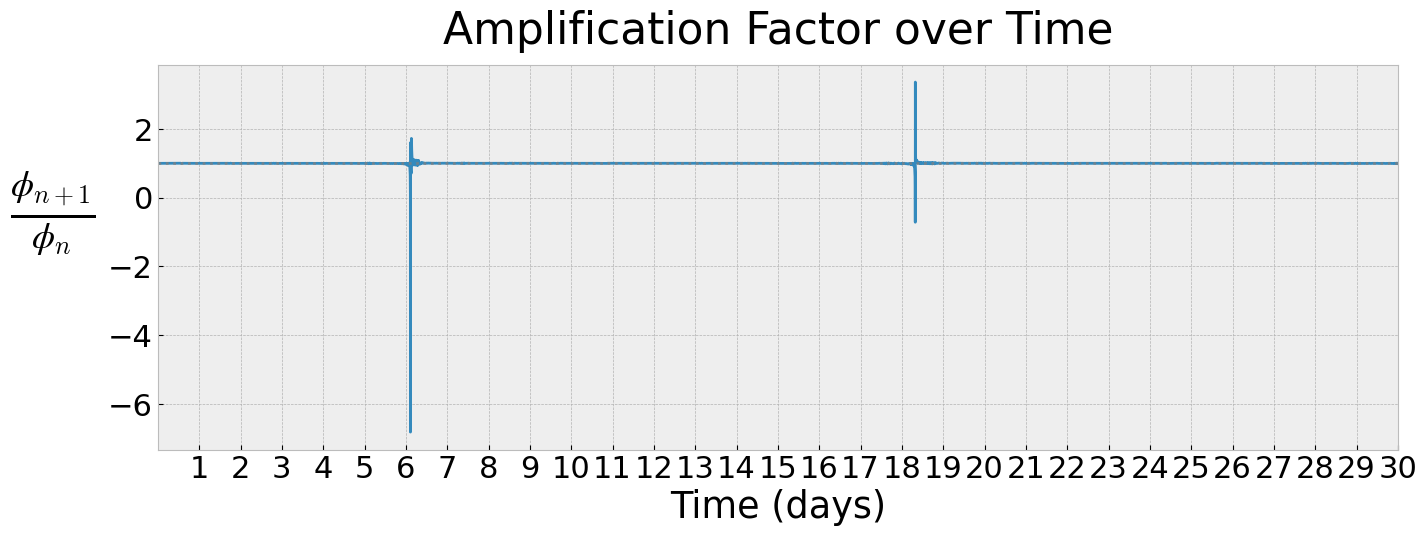

In [44]:
[y_max, x_max] = np.unravel_index(
    np.argmax(geopotential_height[0]), 
    np.shape(geopotential_height[0])
)
amplification_factor = [geopotential_height[i, y_max, x_max]/geopotential_height[i-1, y_max, x_max] for i in range(1, nt)]
# amplification_factor = [
#     np.max(time_filtered_geopotential_height[i])/np.max(time_filtered_geopotential_height[i-1]) for i in range(1, nt)
# ]


plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16,5))
ax.set_title('Amplification Factor over Time', pad=15)

ax.plot(
    time_points[1:]/SECONDS_PER_DAY, 
    amplification_factor
)

ax.axhline(y=1, color='gray', alpha=0.75, ls=':')

ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=n_days, prune='lower'))

ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{ϕ_{n+1}}{ϕ_{n}}$", rotation=0, labelpad=40, fontsize=38)
        
# ax.set_ylim(0.99, 1.01)
ax.set_xlim(0, n_days)

fig.savefig(f"{output_file_directory}/{simulation_name}_amplification-factor.png", dpi=300)

# Ahmed (2021) Solutions

## Physical Constants

In [2]:
simulation_moisture = True
simulation_damping = True
moisture_coupling = False

############################ Fundamental Constants #############################
GRAVITY = 9.81                           # g [m/s^2]
EQUIVALENT_DEPTH = 250.                  # H [m]
CORIOLIS_PARAMETER = 2.29e-11            # ß [m^-1 s^-1]
EARTH_RADIUS = 6371.0072e3               # R_e [m]
AIR_DENSITY = 1.225                      # ρ_a [kg m^-3]
WATER_DENSITY = 997                      # ρ_w [kg m^-3]
LATENT_HEAT = 2260000                    # L_v [J kg^-1 K^-1]
SPECIFIC_HEAT = 1004                     # c_p [J kg^-1]

#### Ahmed (2021) constants ####
GROSS_DRY_STABILITY = 3.12e4             # M_s [K kg m^-2]

MOISTURE_SENSITIVITY = 0.00              # ε_q [s^-1]
TEMPERATURE_SENSITIVITY = 0.00           # ε_t [s^-1]
CLOUD_RADIATIVE_PARAMETER = 0            # r [-]

sigma_x_multiplier = 0                   # n_σ_x[-]
sigma_y_multiplier = 0                   # n_σ_y[-]

if simulation_damping == True:
    TEMPERATURE_SENSITIVITY = 1/(10*3600)   # ε_t [s^-1]
    CLOUD_RADIATIVE_PARAMETER = 0.2         # r [-]

if simulation_moisture == True:
    MOISTURE_SENSITIVITY = 1/(6*3600)       # ε_q [s^-1]
    sigma_x_multiplier = 0                  # n_σ_x[-]
    sigma_y_multiplier = 0                  # n_σ_y[-]

ZONAL_MOISTENING_PARAMETER = 5e-4*sigma_x_multiplier        # σ_x [K kg m^-3]
MERIDIONAL_MOISTENING_PARAMETER = 9e-9*sigma_y_multiplier   # σ_y [K kg m^-4]
##############################################################################


### Conversion factors ###
METERS_PER_DEGREE = 110e3
SECONDS_PER_DAY = 86400
COLUMN_AVERAGE_MASS = 1000*100/9.81
##########################


################################ Derived quantities ##################################
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)         # c_g [m s^-1]
time_scale = (CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)   # T [s]
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)  # L [m]
gross_moisture_stratification = 0.75*GROSS_DRY_STABILITY             # M_q [K kg m^-2]
effective_sensitivity = (
    MOISTURE_SENSITIVITY 
    + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)
)                                                                    # ε_a [s^-1]
effective_gross_moist_stability = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
)*(1+CLOUD_RADIATIVE_PARAMETER) - CLOUD_RADIATIVE_PARAMETER          # m_eff [-]
scaled_zonal_parameter = ZONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_x
scaled_meridional_parameter = MERIDIONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_y


print(f"{'Important Parameter Values':^50}")
print(f"{'':=^50}")
print(f"Dry Gravity Wave Phase Speed:     {gravity_wave_phase_speed:>10.2f} m/s")
print(f"Time Scale:                       {time_scale*24/SECONDS_PER_DAY:>10.2f} hours")
print(f"Length Scale:                     {length_scale/1e3:>10.2f} km")
print(f"")
print(f"Damping: {simulation_damping}")
print(f"- Temperature Sensitivity:        {3600*TEMPERATURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Cloud-Radiative Parameter:      {CLOUD_RADIATIVE_PARAMETER:>10.2f}")
print(f"")
print(f"Moisture: {simulation_damping}")
print(f"- Moisture Sensitivity:           {3600*MOISTURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Zonal Moistening Parameter:     {sigma_x_multiplier:>10.2f} x {ZONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"- Meridional Moistening Parameter:{sigma_y_multiplier:>10.2f} x {MERIDIONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"{'':=^50}")
######################################################################################

            Important Parameter Values            
Dry Gravity Wave Phase Speed:          49.52 m/s
Time Scale:                             8.25 hours
Length Scale:                        1470.57 km

Damping: True
- Temperature Sensitivity:              0.10 hr^-1
- Cloud-Radiative Parameter:            0.20

Moisture: True
- Moisture Sensitivity:                 0.17 hr^-1
- Zonal Moistening Parameter:           0.00 x 0.0e+00
- Meridional Moistening Parameter:      0.00 x 0.0e+00


## Simulation Parameters

In [4]:
########################### Define simiulaton grid ############################
n_days                   = 120                    # number of days in simulation
n_time_steps             = 3*2**14                 # number of time steps
meridional_domain_length = 5000e3                # length of half y domain in m
meridional_step_size     = 50e3                 # meridional grid spacing in m
zonal_domain_length      = 2*np.pi*EARTH_RADIUS  # length of x domain in m
zonal_step_size          = 200e3                 # zonal grid spacing in m

simulation_length = n_days*SECONDS_PER_DAY       # simulation length in seconds
time_points = np.linspace(
    0, 
    simulation_length, 
    n_time_steps
)                                                # Array of simulation time points  
time_step = np.diff(time_points)[0]              # Length of a time step in s

meridional_gridpoints = np.arange(                                               
    -meridional_domain_length,
     meridional_domain_length,
     meridional_step_size
)                                                # meridional grid points

zonal_gridpoints = np.arange(                                               
    -zonal_domain_length/2,
     zonal_domain_length/2,
     zonal_step_size 
)                                                # zonal grid points 

nt = len(time_points)                            # number of time steps
ny = len(meridional_gridpoints)                  # number of zonal grid points
nx = len(zonal_gridpoints)                       # number of meridional grid points

# Calculate CFL condition
CFL_x = gravity_wave_phase_speed*time_step/zonal_step_size
CFL_y = gravity_wave_phase_speed*time_step/meridional_step_size

print(f"{'Simulation Parameters':^48}")
print(f"{'':=^48}")
print(
    f"{'Lx =':4}" + 
    f"{zonal_domain_length/1e3:>6.0f}{' km':<6}" + 
    f"{'| Δx = ':>5}" + 
    f"{zonal_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| nx = ':<5}" + 
    f"{nx:>5.0f}"
)
print(
    f"{'Ly =':4}" + 
    f"{2*meridional_domain_length/1e3:>6.0f}" + 
    f"{' km':<6}{'| Δy = ':>5}" + 
    f"{meridional_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| ny = ':<4}" + 
    f"{ny:>5.0f}"
)
print(
    f"{'T  =':4}" + 
    f"{simulation_length/SECONDS_PER_DAY:>6.0f}" + 
    f"{' days':<6}{'| Δt = ':>5}" + 
    f"{time_step:>8.1f}" + 
    f"{' sec':<5}" + 
    f"{'| nt = ':<5}" + 
    f"{nt:>5.0f}"
)
print(f"{'':=^48}")
print(f"CFL_x = {CFL_x:0.3f}", end="")
if (CFL_x < 1/(np.sqrt(2)*np.pi)):
    print(", numerically stable ✔")
else:
    print(", CFL > 1/(π√2), numerically unstable!!")

    
print(f"CFL_y = {CFL_y:0.3f}", end="")
if (CFL_y < 1/(np.sqrt(2)*np.pi)):
    print(", numerically stable ✔")
    
else:
    print(", CFL > 1/(π√2), numerically unstable!!")
    
print(f"{'':=^48}")
###########################################################################################

             Simulation Parameters              
Lx = 40030 km   | Δx =    200.0 km  | nx =   201
Ly = 10000 km   | Δy =     50.0 km  | ny =   200
T  =   120 days | Δt =    210.9 sec | nt = 49152
CFL_x = 0.052, numerically stable ✔
CFL_y = 0.209, numerically stable ✔


## Compute Solutions

### Initial Conditions

Output directory: output/Ahmed-21/Ahmed-21_epst=0.10_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-uncoupled-simulation
Initial condition: k=1.0_m=1_Kelvin-wave


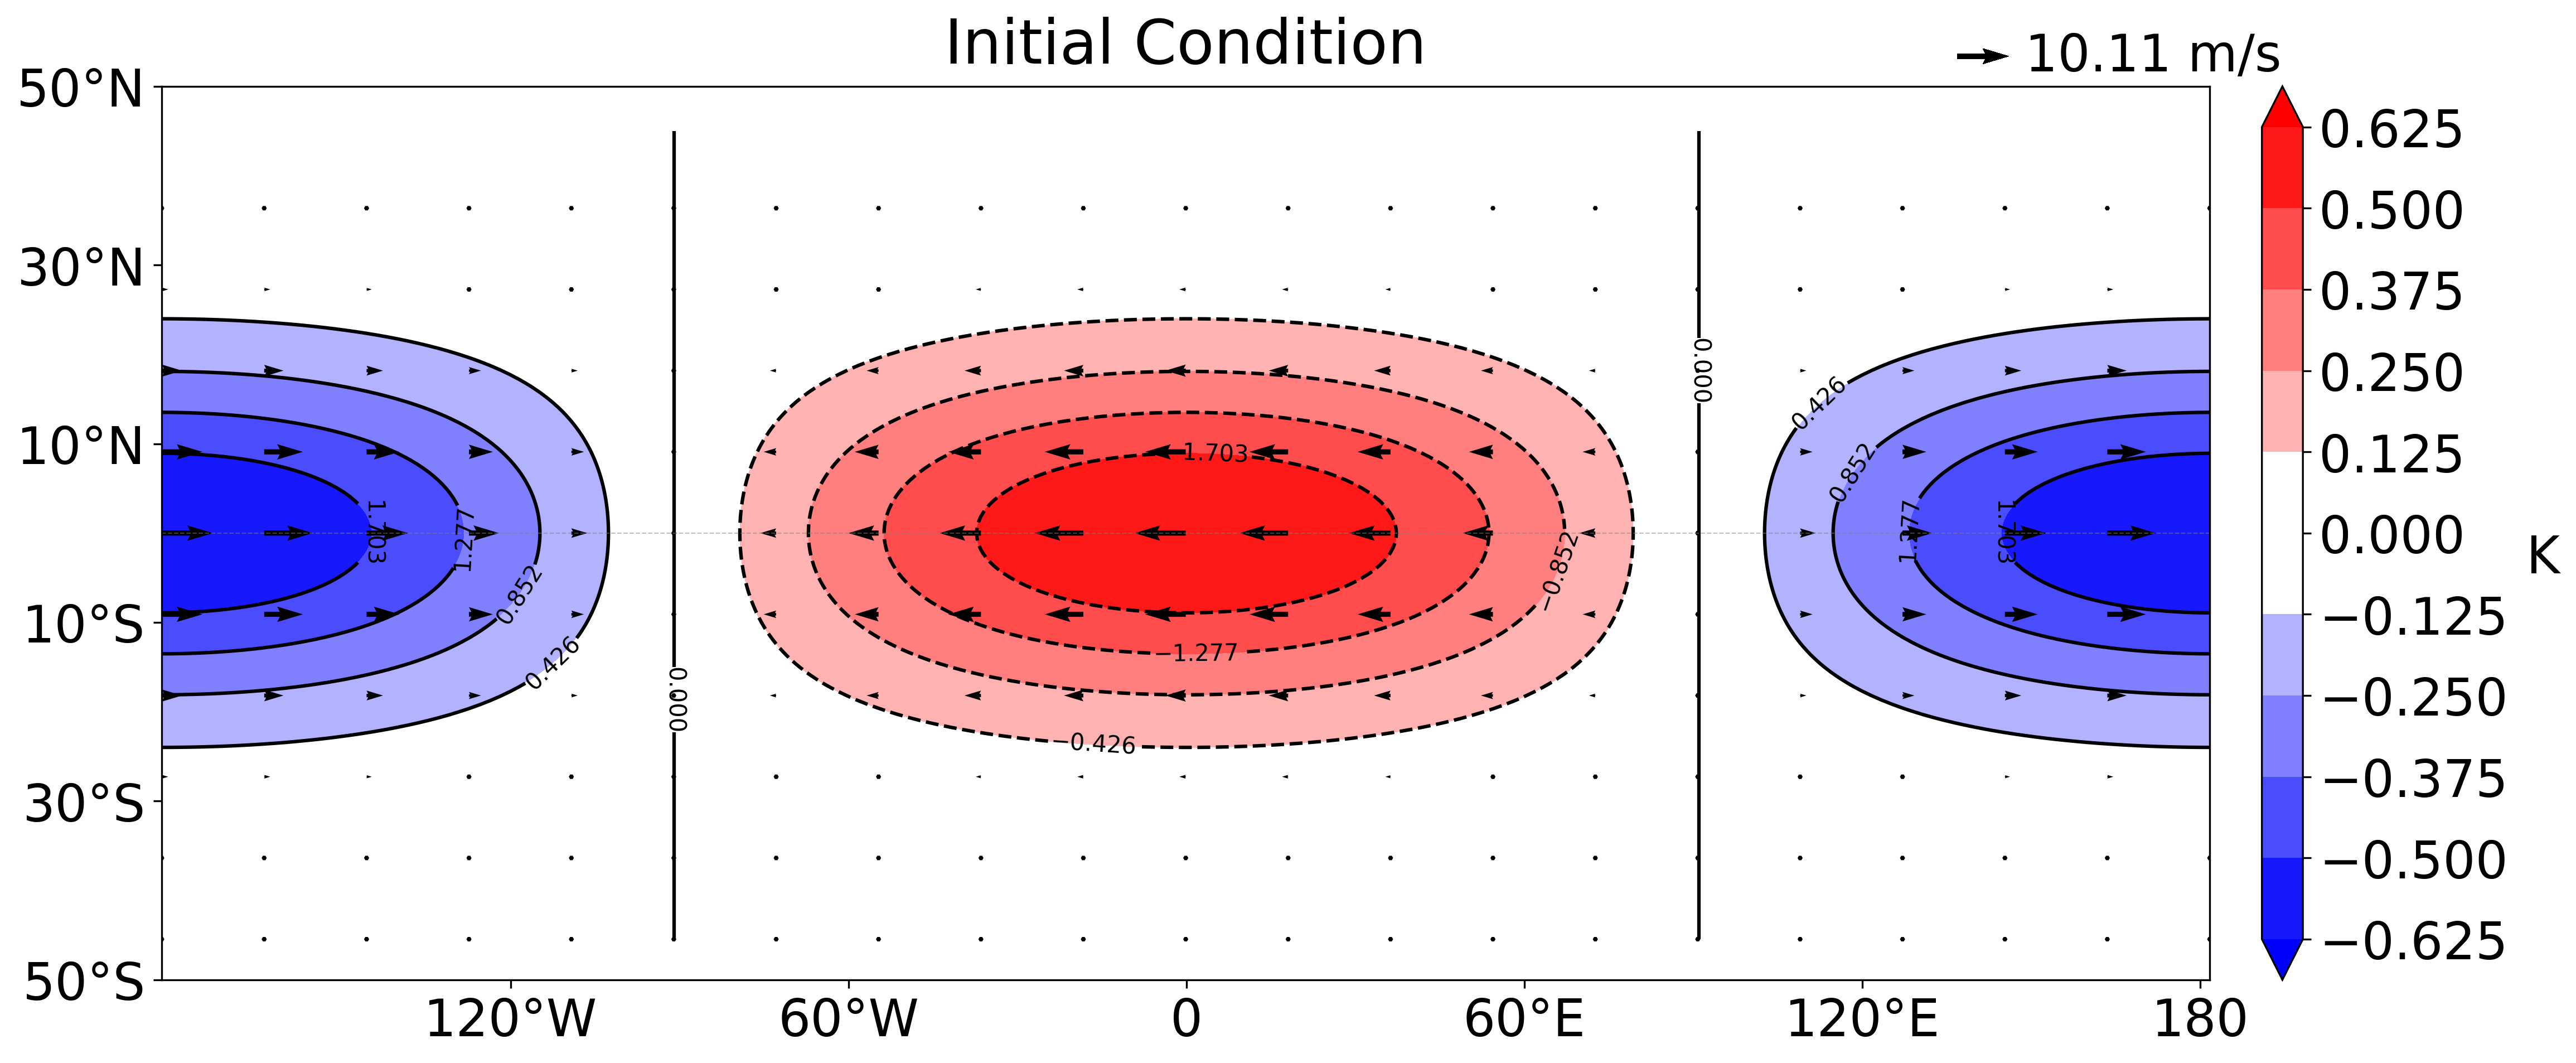

In [5]:
### Initialize arrays
zonal_velocity = np.zeros((nt,ny,nx))
meridional_velocity = np.zeros((nt,ny,nx))
column_temperature = np.zeros((nt,ny,nx))
column_moisture = np.zeros((nt, ny,nx))

if simulation_damping == True:
    damping_state = 'damped'
else:
    damping_state = 'free'
    
if simulation_moisture == True:
    moisture_state = 'moist'
else:
    moisture_state = 'dry'
    
    
if moisture_coupling == True:
    coupling_state = 'coupled'
else:
    coupling_state = 'uncoupled'

initial_wave = 'Kelvin'
n_wavelengths = 1
initial_wavenumber = 2*np.pi*n_wavelengths/zonal_domain_length
mode_number = 1
initial_temperature_anomaly = COLUMN_AVERAGE_MASS/1.6


if initial_wave == 'Kelvin':
    
    # u(x,y,t=0) = c × ψ(y/L, 1) × e^(ikx) [m s^-1]
    zonal_velocity[0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ij',
            mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
            np.exp(1j*initial_wavenumber*zonal_gridpoints)
        )
    )
    
    # <T>(x,y,t=0)
    column_temperature[0] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
        np.einsum(
            'i,j->ij',
            mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
            np.exp(1j*initial_wavenumber*zonal_gridpoints)
        )
    )
    
    if simulation_moisture == True:
        column_moisture[0] = -(gross_moisture_stratification/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
            np.einsum(
                'i,j->ij',
                mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )
    
    # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
    zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
    column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
    column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
    
    
else:
    if initial_wave == 'Rossby':
        initial_frequency = (
            CORIOLIS_PARAMETER*initial_wavenumber
            /(initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number+1))
        )

    elif initial_wave == 'EIG':
        initial_frequency = -gravity_wave_phase_speed*np.sqrt(
                initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
            )

    elif initial_wave == 'WIG':
        initial_frequency = gravity_wave_phase_speed*np.sqrt(
                initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
            )


    # v(x,y,t=0) = i(1/ß)(ω^2-(ck)^2) × ψ(y/L, m) × e^(ikx) [m s^-1]
    meridional_velocity[0] = np.real(
            np.einsum(
                'i,j->ij',
                (
                    1j*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)*(1/CORIOLIS_PARAMETER)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
    zonal_velocity[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
            np.einsum(
                'i,j->ij',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                    + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

    # <T>(x,y,t=0) =  (M_s/c) x L × (0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [K kg m^-2]
    column_temperature[0] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed)*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
            np.einsum(
                'i,j->ij',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                    - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                ),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )
    
    if simulation_moisture == True:
        column_moisture[0] = -(gross_moisture_stratification/gravity_wave_phase_speed)*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                        - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

    # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
    zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
    meridional_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
    column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
    column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
    

# Convert the units of temperature and moisture
average_temperature = np.copy(column_temperature)/COLUMN_AVERAGE_MASS
equivalent_moisture = np.copy(column_moisture)/LATENT_HEAT*SPECIFIC_HEAT*1000/WATER_DENSITY
#################################

##################### Specify output directories #####################
os.chdir("/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")

simulation_name = (
    f"Ahmed-21"
  + f"_epst={3600*TEMPERATURE_SENSITIVITY:0.2f}"
  + f"_epsq={3600*MOISTURE_SENSITIVITY:0.2f}"
  + f"_r={CLOUD_RADIATIVE_PARAMETER:0.1f}"
  + f"_nx={sigma_x_multiplier:0.1f}"
  + f"_ny={sigma_y_multiplier:0.1f}"
  + f"_{damping_state}-{moisture_state}-{coupling_state}-simulation"
)

initial_condition_name = (
      f"k={initial_wavenumber*zonal_domain_length/(2*np.pi):0.1f}" 
    + f"_m={mode_number}"
    + f"_{initial_wave}-wave"
)

output_file_directory = f"output/Ahmed-21/{simulation_name}"
if not os.path.exists(output_file_directory):
    os.mkdir(output_file_directory)

print(f"Output directory: {output_file_directory}")
print(f"Initial condition: {initial_condition_name}")
#####################################################################


############################ Plot initial conditions ############################
plt.style.use('default')
plt.rcParams.update({'font.size':22})
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

# Specify quiver spacing
n_quiver_points = 10
zonal_quiver_plot_spacing = int((1/n_quiver_points/2)*zonal_domain_length/zonal_step_size)
meridional_quiver_plot_spacing = int((1/n_quiver_points)*2*meridional_domain_length/meridional_step_size)

plotting_units = 'converted'

if plotting_units == 'natural':
    plotting_temperature = column_temperature
    temperature_units = r"$\frac{K \, kg}{m^2}$"
    plotting_moisture = column_moisture
    

elif plotting_units == 'converted':
    plotting_temperature = average_temperature
    temperature_units = r"K"
    plotting_moisture = equivalent_moisture

quiver_scale = np.max(zonal_velocity[0])
contourf_scale = np.max(plotting_temperature[0])
contour_scale = np.max(plotting_moisture[0])
grid_scaling = 1e-6

contourf_args = {
    'levels' :  np.linspace(
                    -contourf_scale, 
                     contourf_scale, 
                     11
                ),
    # 'levels' :  11,
    'norm'   :  mcolors.CenteredNorm(),
    'cmap'   :  modified_cmap, 
    'extend' :  'both'
}

contour_args = {
    'levels' :  np.linspace(
                    -contour_scale,
                     contour_scale,
                     11
                ),
    # 'levels' :  11,
    'norm'   :  mcolors.CenteredNorm(),
    'colors' : 'black'
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.99, bottom=0.1, wspace=0.05)

Tbar_ax = fig.add_subplot(gs[-1])
ax = fig.add_subplot(gs[0])

# ax.set_title('Initial Condition', pad=15)

T_cont = ax.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_temperature[0],
    **contourf_args
)

cbar = fig.colorbar(T_cont, cax=Tbar_ax)
cbar.set_ticks(contourf_args['levels'])
cbar.set_label(temperature_units, rotation=0, labelpad=15)

q_cont = plt.contour(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_moisture[0],
    **contour_args
)
ax.clabel(q_cont, q_cont.levels, inline=True, fontsize=10)

quiv = ax.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    -zonal_velocity[0][::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    -meridional_velocity[0][::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)
ax.quiverkey(
    quiv,          
    0.79, 1.02,          
    U=quiver_scale,          
    label=f'{quiver_scale:0.2f} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)
 
ax.set_title('Initial Condition', pad=10)

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

latitude_ticks = np.arange(-50, 50+20, 20)
# latitude_ticks = np.arange(-10, 10+5, 5)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

ax.set_aspect('auto')

# plt.show()
plt.savefig(f"{output_file_directory}/{initial_condition_name}_intial-condition.png", bbox_inches='tight')

### Document simulation parameters

In [6]:
if not os.path.exists(f"{output_file_directory}/documentation.txt"):
    f = open(f"{output_file_directory}/documentation.txt", "w+")
    
    f.write(f"Physical Constants {'':=^50}\n")
    f.write(f"gravity                                  {GRAVITY:>10.3f} m/s^2 \n")
    f.write(f"equivalent depth                         {EQUIVALENT_DEPTH:>10.3f} m \n")
    f.write(f"dry gravity wave phase speed             {gravity_wave_phase_speed:>10.3f} m s^-1 \n")
    f.write(f"coriolis parameter                       {CORIOLIS_PARAMETER*1e11:>10.3f} x 10^-11 m^-1 s^-1 \n")
    f.write(f"earth radius                             {EARTH_RADIUS/1e3:>10.3f} km \n")
    f.write(f"air density                              {AIR_DENSITY:>10.3f} kg m^-3 \n")
    f.write(f"water density                            {WATER_DENSITY:>10.3f} kg m^-3 \n")
    f.write(f"latent heat of vaporization              {LATENT_HEAT/1e3:>10.3f} KJ kg^-1 \n")
    f.write(f"specific heat capacity                   {SPECIFIC_HEAT:>10.3f} J kg^-1 K^-1 \n")
    f.write(f"\n")
    
    f.write(f"Ahmed 2021 Constants {'':=^50}\n")
    f.write(f"gross dry stability                      {GROSS_DRY_STABILITY/1e4:>10.3f} x 10^4 K kg m^-2 \n")
    f.write(f"gross mositure stratification            {gross_moisture_stratification/1e4:>10.3f} x 10^4 K kg m^-2 \n")
    f.write(f"convective sensitivity to moisture       {3600*MOISTURE_SENSITIVITY:>10.3f} hr^-1 \n")
    f.write(f"convective sensitivity to temperature    {3600*TEMPERATURE_SENSITIVITY:>10.3f} hr^-1 \n")
    f.write(f"cloud radiative feedback parameter       {CLOUD_RADIATIVE_PARAMETER:>10.3f} \n")
    f.write(f"zonal moisture gradient parameter          {ZONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-3 \n")
    f.write(f"meridional moisture gradient parameter     {MERIDIONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-4 \n")
    f.write(f"\n")
    
    f.write(f"Other Parameters {'':=^50}\n")
    f.write(f"length scale                             {length_scale/1e3:>10.3f} km \n")
    f.write(f"time scale                               {time_scale/3600:>10.3f} hr \n")
    f.write(f"CFL condition in x                       {CFL_x:>10.3f} \n")
    f.write(f"CFL condition in y                       {CFL_y:>10.3f} \n")
    f.write(f"\n")
    
    f.write(f"Simulation Parameters {'':=^50}\n")
    f.write(f"simulation length                        {n_days:>10.3f} days \n")
    f.write(f"time step length                         {time_step/3600:>10.3f} hr \n")
    f.write(f"number of time steps                     {nt:>10.3f} \n")
    f.write(f"zonal domain length                      {zonal_domain_length/1e3:>10.3f} km \n")
    f.write(f"zonal step size                          {zonal_step_size/1e3:>10.3f} km \n")
    f.write(f"number of zonal steps                    {nx:>10.3f} \n")
    f.write(f"meridional domain length                 {2*meridional_domain_length/1e3:>10.3f} km \n")
    f.write(f"meridional step size                     {meridional_step_size/1e3:>10.3f} km \n")
    f.write(f"number of meridional steps               {ny:>10.3f} \n")
    f.write(f"{'':=^72}\n")
    
    f.close()
print("Documentation created")

Documentation created


### Solve

In [7]:
#### Define Fourier arrays 
zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies

### Initialize leapfrog method with one step forward

### Transform to wavenumber space
ux_fft = fft(zonal_velocity[0],axis=1)
vy_fft = fft(meridional_velocity[0],axis=0)
Tx_fft = fft(column_temperature[0],axis=1)
Ty_fft = fft(column_temperature[0],axis=0)

### Compute derivatives
dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft
    
### Transform back to physical space
dudx = np.real(ifft(dudx_fft,axis=1))
dvdy = np.real(ifft(dvdy_fft,axis=0))
dTdx = np.real(ifft(dTdx_fft,axis=1))
dTdy = np.real(ifft(dTdy_fft,axis=0))

### Step forward one time step
# u[1] = u[0] - Δt × (-ßyv[0] + (c^2/M_s)d<T>[0]/dx)
zonal_velocity[1] = zonal_velocity[0] - time_step*(
    - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
    + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx
)

# v[1] = v[0] - Δt × (ßyu[0] + (c^2/M_s)d<T>[0]/dy)
meridional_velocity[1] = meridional_velocity[0] - time_step*(
    + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[0] 
    + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy
)

# <T>[1] = <T>[0] - Δt × (M_s(du[0]/dx + dv[0]/dy) + ε_t(1+r)<T>[0] - ε_q(1+r)<q>)
if moisture_coupling == True:
    column_temperature[1] = column_temperature[0] - time_step*(
        + GROSS_DRY_STABILITY*(dudx + dvdy) 
        + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
        - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[0]
    )

elif moisture_coupling == False:
    column_temperature[1] = column_temperature[0] - time_step*(
        + GROSS_DRY_STABILITY*(dudx + dvdy) 
        + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
    )

if simulation_moisture == True:
    # <q>[1] = <q>[0] - Δt × (-σ_x×u[0] + σ_y×y×v[0] - M_q(du[0]/dx + dv[0]/dy) - ε_t<T>[0] + ε_q<q>[0])
    column_moisture[1] = column_moisture[0] - time_step*(
        - ZONAL_MOISTENING_PARAMETER*zonal_velocity[0]
        + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
        - gross_moisture_stratification*(dudx + dvdy) 
        - TEMPERATURE_SENSITIVITY*column_temperature[0]
        + MOISTURE_SENSITIVITY*column_moisture[0]   
    )

### Meridional boundary condition
meridional_velocity[1,0,:] = 0.
meridional_velocity[1,-1,:] = 0.
        
### Step forward using leapfrong time-differencing
for it in tqdm(range(2,nt), position=0, leave=True, ncols=100):
    ### Transform to spectral space
    ux_fft = fft(zonal_velocity[it-1],axis=1)
    vy_fft = fft(meridional_velocity[it-1],axis=0)
    Tx_fft = fft(column_temperature[it-1],axis=1)
    Ty_fft = fft(column_temperature[it-1],axis=0)

    ### Compute derivatives
    dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
    dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

    ### Transform back to physical space
    dudx = np.real(ifft(dudx_fft,axis=1))
    dvdy = np.real(ifft(dvdy_fft,axis=0))
    dTdx = np.real(ifft(dTdx_fft,axis=1))
    dTdy = np.real(ifft(dTdy_fft,axis=0))

    ### Step forward with leapfrog scheme
    zonal_velocity[it] = (zonal_velocity[it-2] - 2*time_step*(
        - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
        + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx)
    )
    
    meridional_velocity[it] = (meridional_velocity[it-2] - 2*time_step*(
        + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[it-1] 
        + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy)
    )
    
    if moisture_coupling == True:
        column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
            column_temperature[it-2] 
            - 2*time_step*(
                + GROSS_DRY_STABILITY*(dudx + dvdy)
                - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[it-1]
            )
        )
    
    elif moisture_coupling == False:
        column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
            column_temperature[it-2] 
            - 2*time_step*(
                + GROSS_DRY_STABILITY*(dudx + dvdy)

            )
        )
    
    if simulation_moisture == True:
        column_moisture[it] = (1/(1+2*MOISTURE_SENSITIVITY*time_step))*(
            column_moisture[it-2] 
            - 2*time_step*(
                - ZONAL_MOISTENING_PARAMETER*zonal_velocity[it-1]
                + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
                - gross_moisture_stratification*(dudx + dvdy)
                - TEMPERATURE_SENSITIVITY*column_temperature[it-1]
            )
        )
    
    ### Meridional boundary condition
    meridional_velocity[it,0] = 0.
    meridional_velocity[it,-1] = 0

100%|█████████████████████████████████████████████████████████| 49150/49150 [10:23<00:00, 78.86it/s]


## Simulation Output

### Horizontal Structure

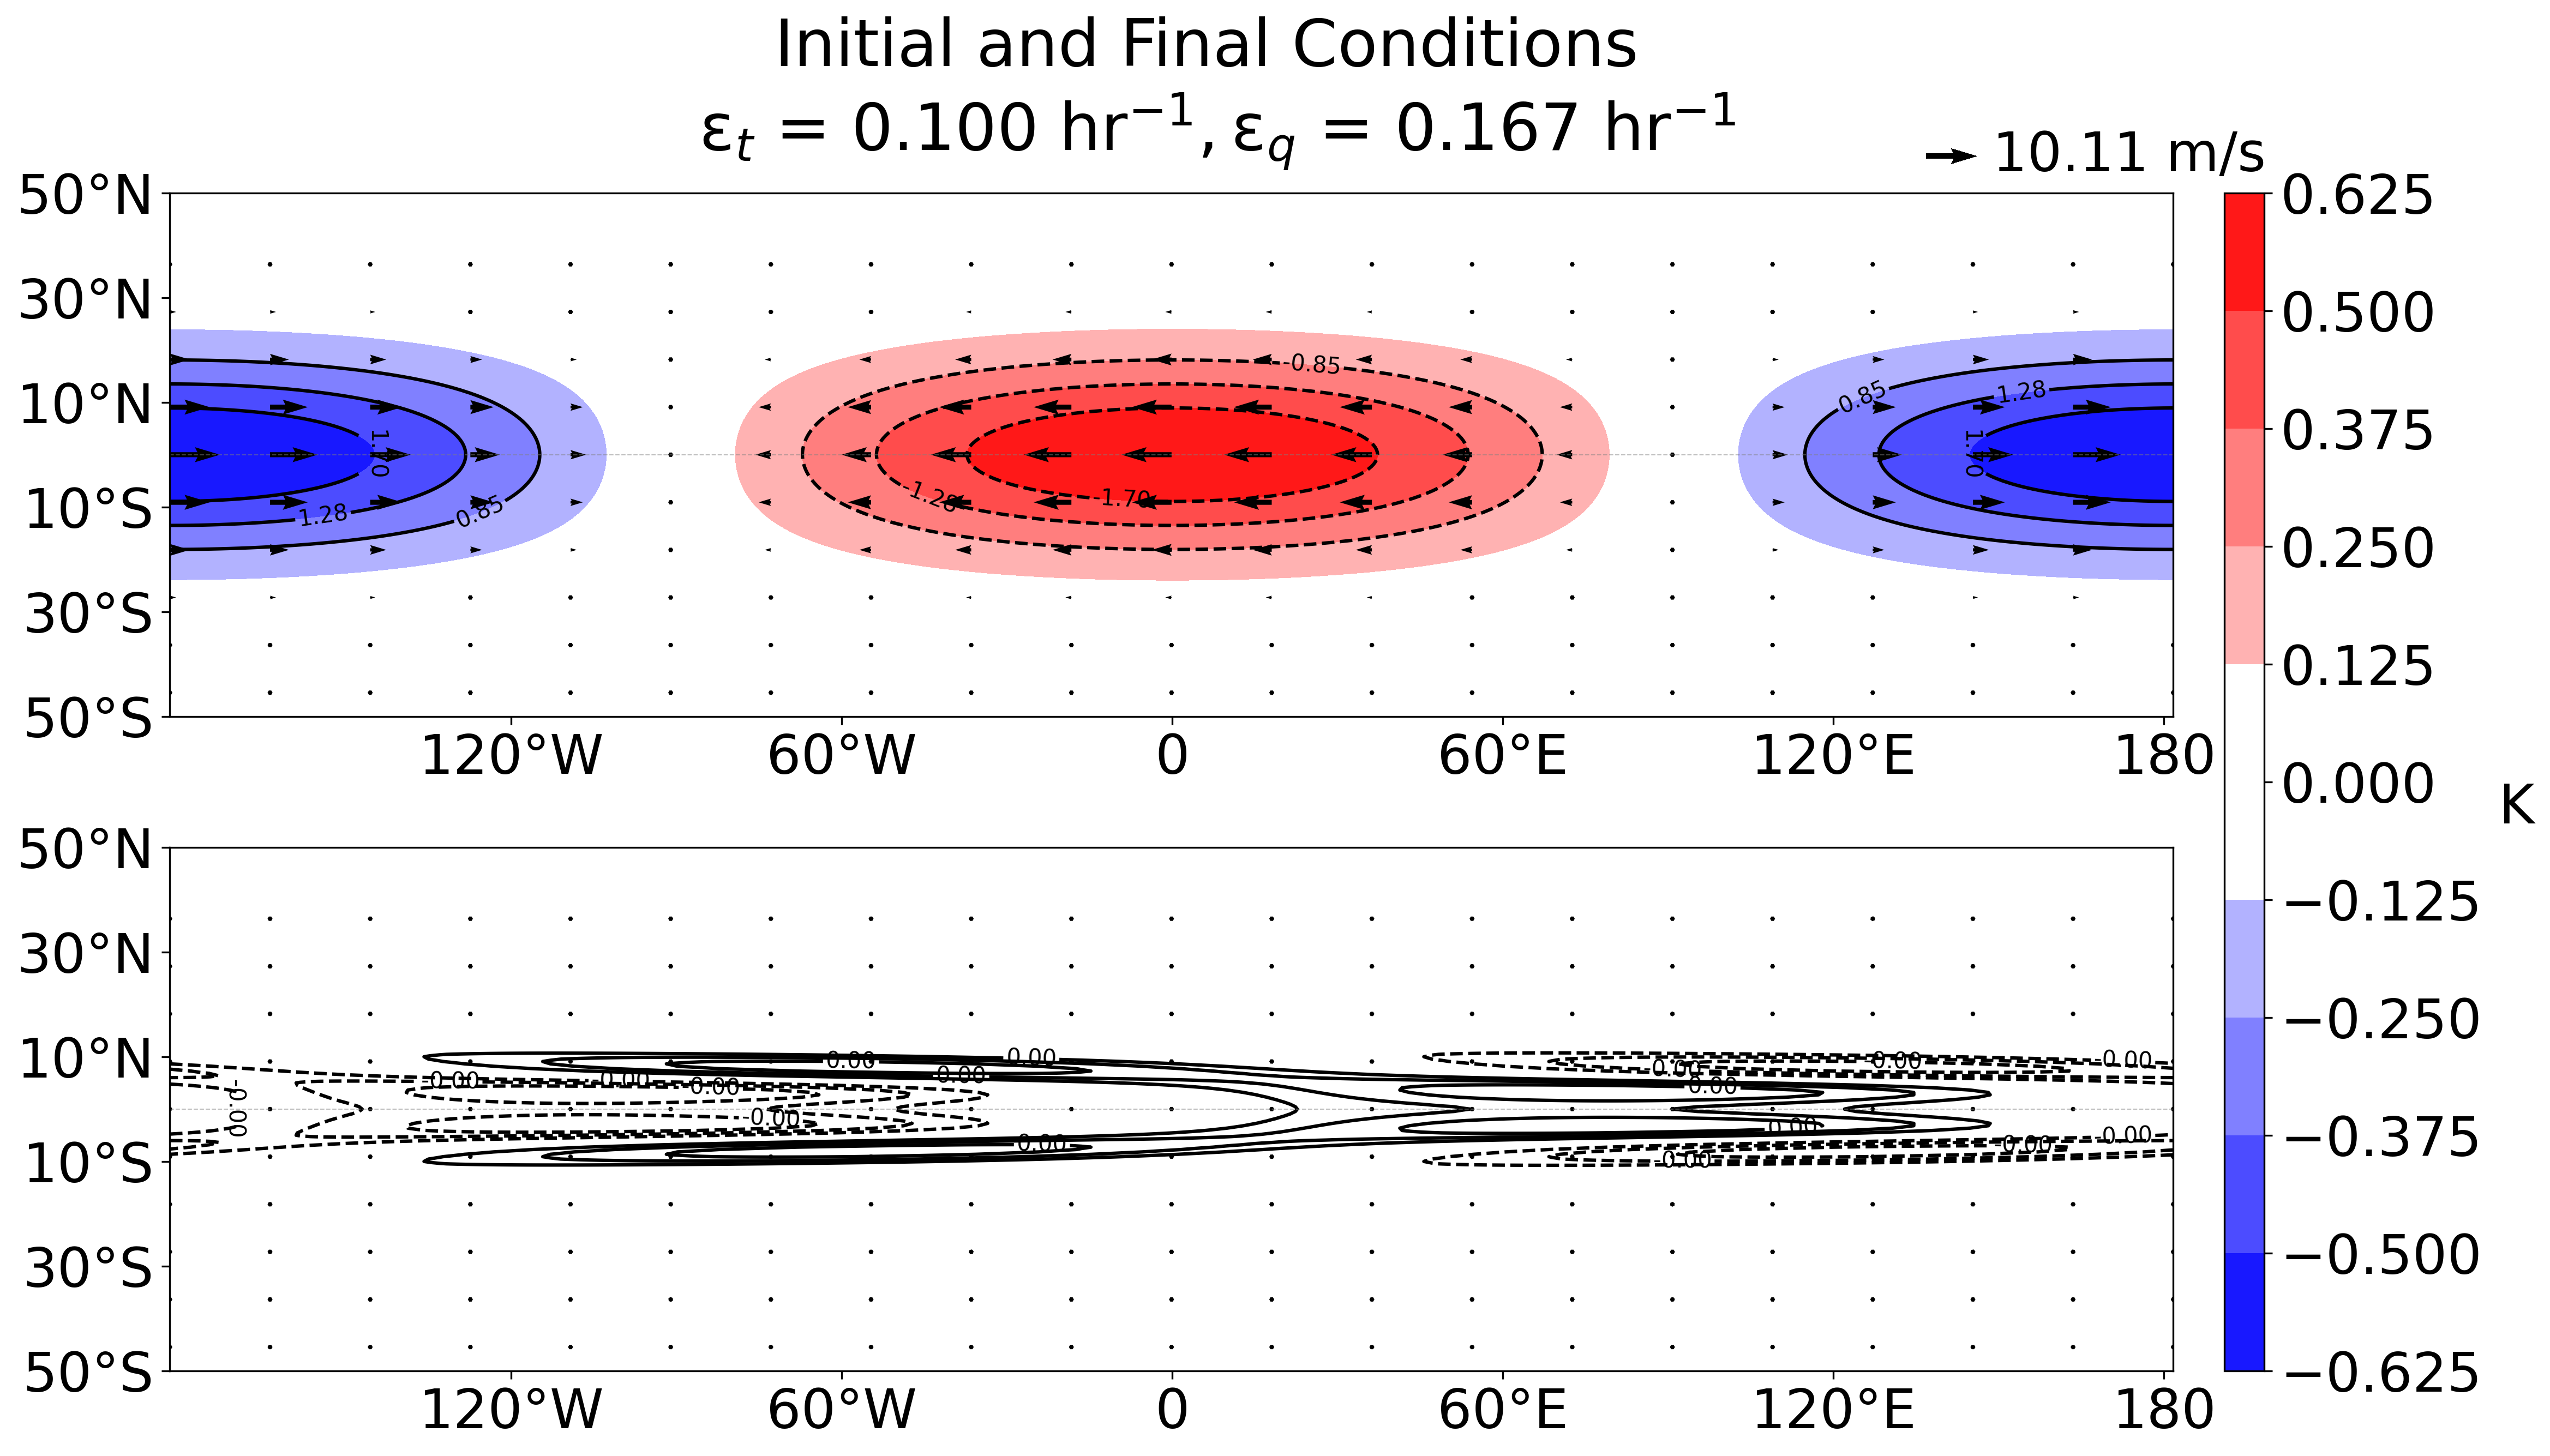

In [8]:
# Calculate equivalent units
average_temperature = np.copy(column_temperature)/COLUMN_AVERAGE_MASS
equivalent_moisture = np.copy(column_moisture)*(SPECIFIC_HEAT/LATENT_HEAT)*(1000/WATER_DENSITY)

plotting_units = 'converted'

if plotting_units == 'natural':
    plotting_temperature = column_temperature
    temperature_units = r"$\frac{K \, kg}{m^2}$"
    plotting_moisture = column_moisture
    
elif plotting_units == 'converted':
    plotting_temperature = average_temperature
    temperature_units = r"K"
    plotting_moisture = equivalent_moisture
    
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

end_frame = -10

contourf_scale = np.max(plotting_temperature)
contour0_scale = np.max(plotting_moisture[0])
contour1_scale = np.max(plotting_moisture[end_frame])
quiver_scale = np.max(zonal_velocity)
grid_scaling = 1e-6

contourf_args = {
    'levels' : np.linspace(-contourf_scale, contourf_scale, 11),
    # 'levels' : 11, 
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    # 'extend' : 'both'    
}

contour0_args = {
    'levels' : np.delete(np.linspace(-contour0_scale, contour0_scale, 11), [4,5,6]),
    # 'levels' : 11, 
    'norm'   : mcolors.CenteredNorm(),
    'colors' : 'black'     
}

contour1_args = {
    'levels' : np.delete(np.linspace(-contour1_scale, contour1_scale, 11), [4,5,6]),
    # 'levels' : 11, 
    'norm'   : mcolors.CenteredNorm(),
    'colors' : 'black'     
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

# Create figure
fig = plt.figure(figsize=(16,9),dpi=300)
gs = GridSpec(2, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

# Label figure
fig.suptitle(
    (
        f"Initial and Final Conditions \n" 
        + r"ε$_t$ = " + f"{3600*TEMPERATURE_SENSITIVITY:0.3f}" + r" hr$^{-1}, $"
        + r"ε$_q$ = " + f"{3600*MOISTURE_SENSITIVITY:0.3f}" + r" hr$^{-1}$"
    ),
    y=1.02
)

#### Initial Condition ####
# Add for the initial condition
Tbar_ax = fig.add_subplot(gs[:, -1])
ax0 = fig.add_subplot(gs[0, 0])

# Plot contours of column temperature anomalies
T_cont = ax0.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_temperature[0],
    **contourf_args
)

Tbar = fig.colorbar(T_cont, cax=Tbar_ax)
Tbar.set_ticks(contourf_args['levels'])
Tbar.set_label(temperature_units, rotation=0, labelpad=15)

q_cont = ax0.contour(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_moisture[0],
    **contour0_args
)

ax.clabel(q_cont, q_cont.levels, fontsize=10, fmt="%1.2f")

# Plot vectors of wind anomalies
quiv = ax0.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    -zonal_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    -meridional_velocity[0,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

# Add a key for the wind vectors
ax0.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale:0.2f} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line on the equator
ax0.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax0.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

latitude_ticks = np.arange(-50, 50+20, 20)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax0.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

# Set the plot aspect
ax0.set_aspect('auto')
#########################

#### Final Condition ####
# Add axes for final condition
ax1 = fig.add_subplot(gs[1, 0])

# Geopotential Height contours
T_cont1 = ax1.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_temperature[end_frame],
    **contourf_args
)

q_cont1 = ax1.contour(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_moisture[end_frame],
    **contour1_args
)

ax1.clabel(q_cont1, q_cont1.levels, fontsize=10, fmt="%1.2f")

# Wind vectors
quiv1 = ax1.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    -zonal_velocity[end_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    -meridional_velocity[end_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

# Equator line
ax1.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Label axes
# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax1.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

latitude_ticks = np.arange(-50, 50+20, 20)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax1.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

# Aspect ratio
ax1.set_aspect('auto')

# plt.show()
plt.savefig(f"{output_file_directory}/{initial_condition_name}_horizontal-structure.png", bbox_inches='tight')

### Temporal Structure

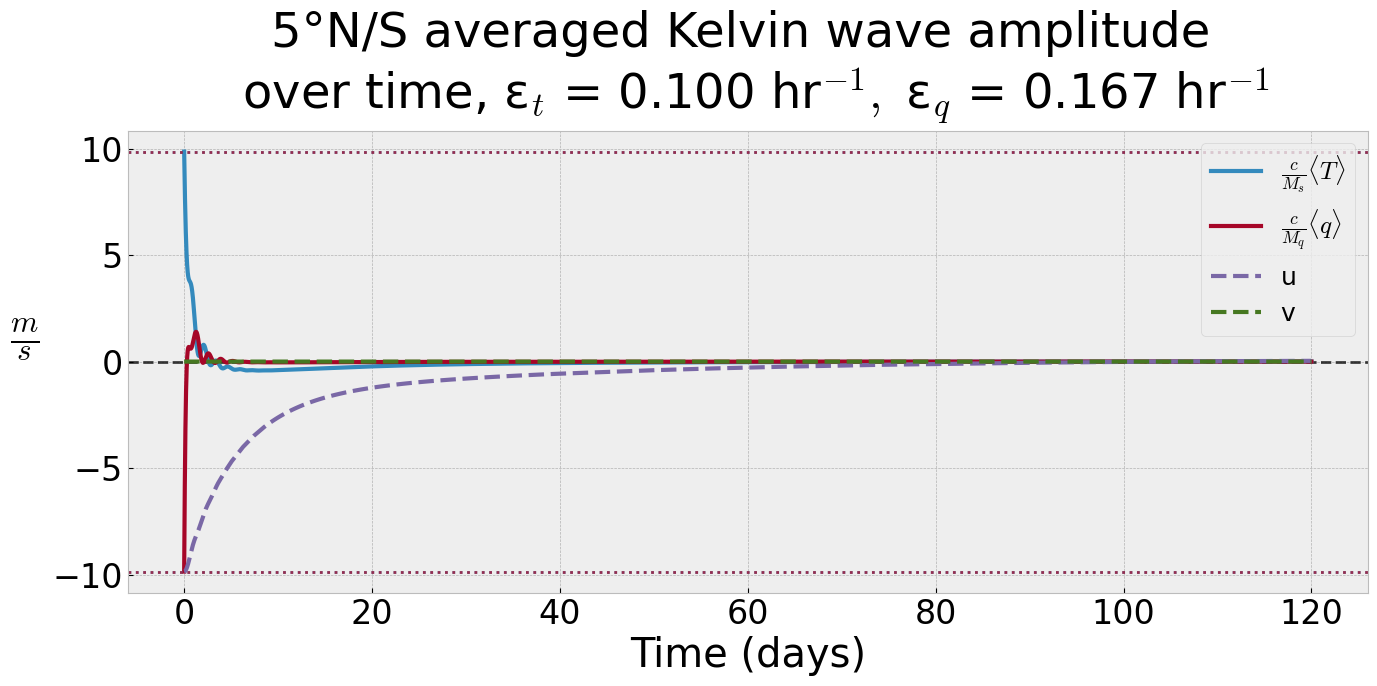

In [9]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

near_equatorial_latitudes = np.where(np.abs(meridional_gridpoints/METERS_PER_DEGREE) <= 5)[0]
near_equatorial_column_temperature = np.mean(column_temperature[:, near_equatorial_latitudes, :], axis=1)
near_equatorial_column_moisture = np.mean(column_moisture[:, near_equatorial_latitudes, :], axis=1)
near_equatorial_zonal_velocity = np.mean(zonal_velocity[:, near_equatorial_latitudes, :], axis=1)
near_equatorial_meridional_velocity = np.mean(meridional_velocity[:, near_equatorial_latitudes, :], axis=1)

max_index = np.argmax(near_equatorial_column_temperature)
[t_index, x_index] = np.unravel_index(max_index, [nt, nx])

[fig, ax] = plt.subplots(figsize=(16,6))
ax.set_title(
    (
        f"5°N/S averaged {initial_wave} wave amplitude \n over time," 
      + r" ε$_t$ = " + f"{3600*TEMPERATURE_SENSITIVITY:0.3f}" + r" hr$^{-1},$"
      + r" ε$_q$ = " + f"{3600*MOISTURE_SENSITIVITY:0.3f}" + r" hr$^{-1}$"
    ), pad=15
)

ax.axhline(
    y=0,
    color='black',
    ls='--',
    alpha=0.75
)

ax.plot(
    time_points/SECONDS_PER_DAY, 
    near_equatorial_column_temperature[:, x_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY, 
    lw=3, 
    label=r"$\frac{c}{M_s}\langle T \rangle$",
    color=bmh_colors('blue')
)

ax.plot(
    time_points/SECONDS_PER_DAY, 
    near_equatorial_column_moisture[:, x_index]*gravity_wave_phase_speed/gross_moisture_stratification, 
    lw=3, 
    label=r"$\frac{c}{M_q}\langle q \rangle$",
    color=bmh_colors('red')
    
)

ax.plot(
    time_points/SECONDS_PER_DAY, 
    -near_equatorial_zonal_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='u',
    color=bmh_colors('purple')
    
)

ax.plot(
    time_points/SECONDS_PER_DAY, 
    -near_equatorial_meridional_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='v',
    color=bmh_colors('green')
)

# Maximum column temperature
ax.axhline(
    y=np.max(near_equatorial_column_temperature)*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_temperature)*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

# Maximum column moisture
ax.axhline(
    y=np.max(near_equatorial_column_moisture)*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_moisture)*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)


ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{m}{s}$", rotation=0, labelpad=20, fontsize=32)

ax.legend(loc='best', fontsize=18)

if initial_wave == 'EIG' or initial_wave == 'WIG':
    plt.xlim(-1, 5)

# plt.show()
plt.savefig(f"{output_file_directory}/{initial_condition_name}_temporal-structure.png", bbox_inches='tight')

### Animate solutions

In [ ]:
# Calculate equivalent units

final_frame = -1
average_temperature = np.copy(column_temperature[:final_frame])/COLUMN_AVERAGE_MASS
equivalent_moisture = np.copy(column_moisture[:final_frame])*(SPECIFIC_HEAT/LATENT_HEAT)*(1000/WATER_DENSITY)

plotting_units = 'converted'

if plotting_units == 'natural':
    plotting_temperature = column_temperature
    temperature_units = r"$\frac{K \, kg}{m^2}$"
    plotting_moisture = column_moisture
    
elif plotting_units == 'converted':
    plotting_temperature = average_temperature
    temperature_units = r"K"
    plotting_moisture = equivalent_moisture

# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})

# Animation parameters
n_frames = 50
starting_frame = 0


if (initial_wave == 'Kelvin') or (initial_wave == 'Rossby'): 
    # frame_interval = int((nt - starting_frame)/n_frames)
    frame_interval = int((np.shape(column_temperature[:-8000,0,0])[0] - starting_frame)/n_frames)
else:
    frame_interval = 50
end_frame = starting_frame + n_frames*frame_interval
frames = np.arange(starting_frame, end_frame, frame_interval)

# Calculate the equivalent pressure perturbation in hPa
contourf_scale = np.max(plotting_temperature)
contour_scale = np.max(plotting_moisture)
quiver_scale = np.max(zonal_velocity[:final_frame])
grid_scaling = 1e-6

contourf_args = {
    'levels' : np.linspace(-contourf_scale, contourf_scale, 11),
    # 'levels' : 11, 
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    # 'cmap' : 'coolwarm',
    'extend' : 'both'    
}

contour_args = {
    # 'levels' : np.delete(np.linspace(-contour_scale, contour_scale, 11), [4,5,6]),
    # 'levels' : 11, 
    'norm'   : mcolors.CenteredNorm(),
    'colors' : 'black'     
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

ax = fig.add_subplot(gs[0])
Tbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time_points[starting_frame]/SECONDS_PER_DAY:0.1f} days")

# Plot filled temperature contours
T_cont = ax.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_temperature[starting_frame],
    **contourf_args
)
Tbar = fig.colorbar(T_cont, cax=Tbar_ax)
Tbar.set_ticks(contourf_args['levels'])
Tbar.set_label(temperature_units, rotation=0, labelpad=15)                  

# # Plot moisture contours
q_cont = ax.contour(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    plotting_moisture[starting_frame],
    levels=np.delete(
        np.linspace(
            -np.max(plotting_moisture[starting_frame]), 
            np.max(plotting_moisture[starting_frame]), 
            11), 
        [4,5,6]
    ),
    **contour_args
)

ax.clabel(q_cont, q_cont.levels, fontsize=10, fmt="%1.2f")

# Plot wind vectors
quiv = ax.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    -zonal_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    -meridional_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)
ax.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale:0.2f} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

# Plot a line at the equator
ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# Set tick labels in longitude/latitude coordinates
longitude_ticks = np.arange(-180+60, 180+60, 60)
longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

latitude_ticks = np.arange(-50, 50+20, 20)
latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

# Set plot aspect
ax.set_aspect('auto')

def update(plotting_index):

    # Clear the plot each frame
    ax.clear()
    
    # Set the title to be the current time of the frame
    ax.set_title(f"Time: {time_points[plotting_index]/SECONDS_PER_DAY:0.1f} days")
    
    # Plot filled temperature contours
    T_cont = ax.contourf(
        zonal_gridpoints*grid_scaling,
        meridional_gridpoints*grid_scaling,
        plotting_temperature[plotting_index],
        **contourf_args
    )
    
    # Plot moisture contours
    q_cont = ax.contour(
        zonal_gridpoints*grid_scaling,
        meridional_gridpoints*grid_scaling,
        plotting_moisture[plotting_index],
        levels=np.delete(
            np.linspace(
                -np.max(plotting_moisture[plotting_index]), 
                np.max(plotting_moisture[plotting_index]), 
                11), 
            [4,5,6]
        ),
        **contour_args
    )
    ax.clabel(q_cont, q_cont.levels, fontsize=10, fmt="%1.2f")
    
    # Plot wind vectors
    quiv = ax.quiver(
        zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
        meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
        -zonal_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        -meridional_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        **quiver_args
    )
    
    ax.quiverkey(
        quiv,          
        0.79, 0.925,          
        U=quiver_scale,          
        label=f'{quiver_scale:0.2f} m/s',          
        coordinates='figure', labelpos='E',          
        color='black', labelcolor='black'
    )
    
    # Set the x and y ticks to be longitude/latitude respectively
    ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
    ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
    
    return T_cont, quiv, q_cont
    
# Run the animation
anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

anim.save(f"{output_file_directory}/{initial_condition_name}_animation.mp4", dpi=300)

## Filtered Solutions

In [17]:
cutoff_days = 20

low_u = mjo.butter_lowpass_filter(zonal_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_v = mjo.butter_lowpass_filter(meridional_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_T = mjo.butter_lowpass_filter(column_temperature.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_q = mjo.butter_lowpass_filter(column_moisture.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T

In [18]:
# phase_speed = np.einsum('i,j->ikj', zonal_wavenumber, frequencies)
frequencies = np.fft.fftfreq(len(time_points), 1/time_step)
phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(meridional_gridpoints), axis=1)

u_fft = np.fft.fft2(low_u, axes=[0,2])
u_fft[np.where(phase_speed<=0)] = 0
u_east = np.real(np.fft.ifft2(u_fft, axes=[0,2]))

v_fft = np.fft.fft2(low_v, axes=[0,2])
v_fft[np.where(phase_speed<=0)] = 0
v_east = np.real(np.fft.ifft2(v_fft, axes=[0,2]))

T_fft = np.fft.fft2(low_T, axes=[0,2])
T_fft[np.where(phase_speed<=0)] = 0
T_east = np.real(np.fft.ifft2(T_fft, axes=[0,2]))

q_fft = np.fft.fft2(low_q, axes=[0,2])
q_fft[np.where(phase_speed<=0)] = 0
q_east = np.real(np.fft.ifft2(q_fft, axes=[0,2]))
# plt.contourf(np.real(test)[0,:,:], cmap='coolwarm', norm=mcolors.CenteredNorm())

In [10]:
# # q_fft = np.fft.fft2(low_q, axes=[0,2])
# mask = np.zeros_like(low_u)
# mask[:,:,10] = 1

# u_fft = np.fft.fft2(low_u, axes=[0,2])
# u_fft_masked = u_fft*mask
# u_1 = np.real(np.fft.ifft2(u_fft_masked, axes=[0,2]))

# v_fft = np.fft.fft2(low_v, axes=[0,2])
# v_fft_masked = v_fft*mask
# v_1 = np.real(np.fft.ifft2(v_fft_masked, axes=[0,2]))

# T_fft = np.fft.fft2(low_T, axes=[0,2])
# T_fft_masked = T_fft*mask
# T_1 = np.real(np.fft.ifft2(T_fft_masked, axes=[0,2]))

# q_fft = np.fft.fft2(low_q, axes=[0,2])
# q_fft_masked = q_fft*mask
# q_1 = np.real(np.fft.ifft2(q_fft_masked, axes=[0,2]))

## Animation

 98%|█████████████████████████████████████████████████████████████▊ | 50/51 [00:52<00:01,  1.60s/it]

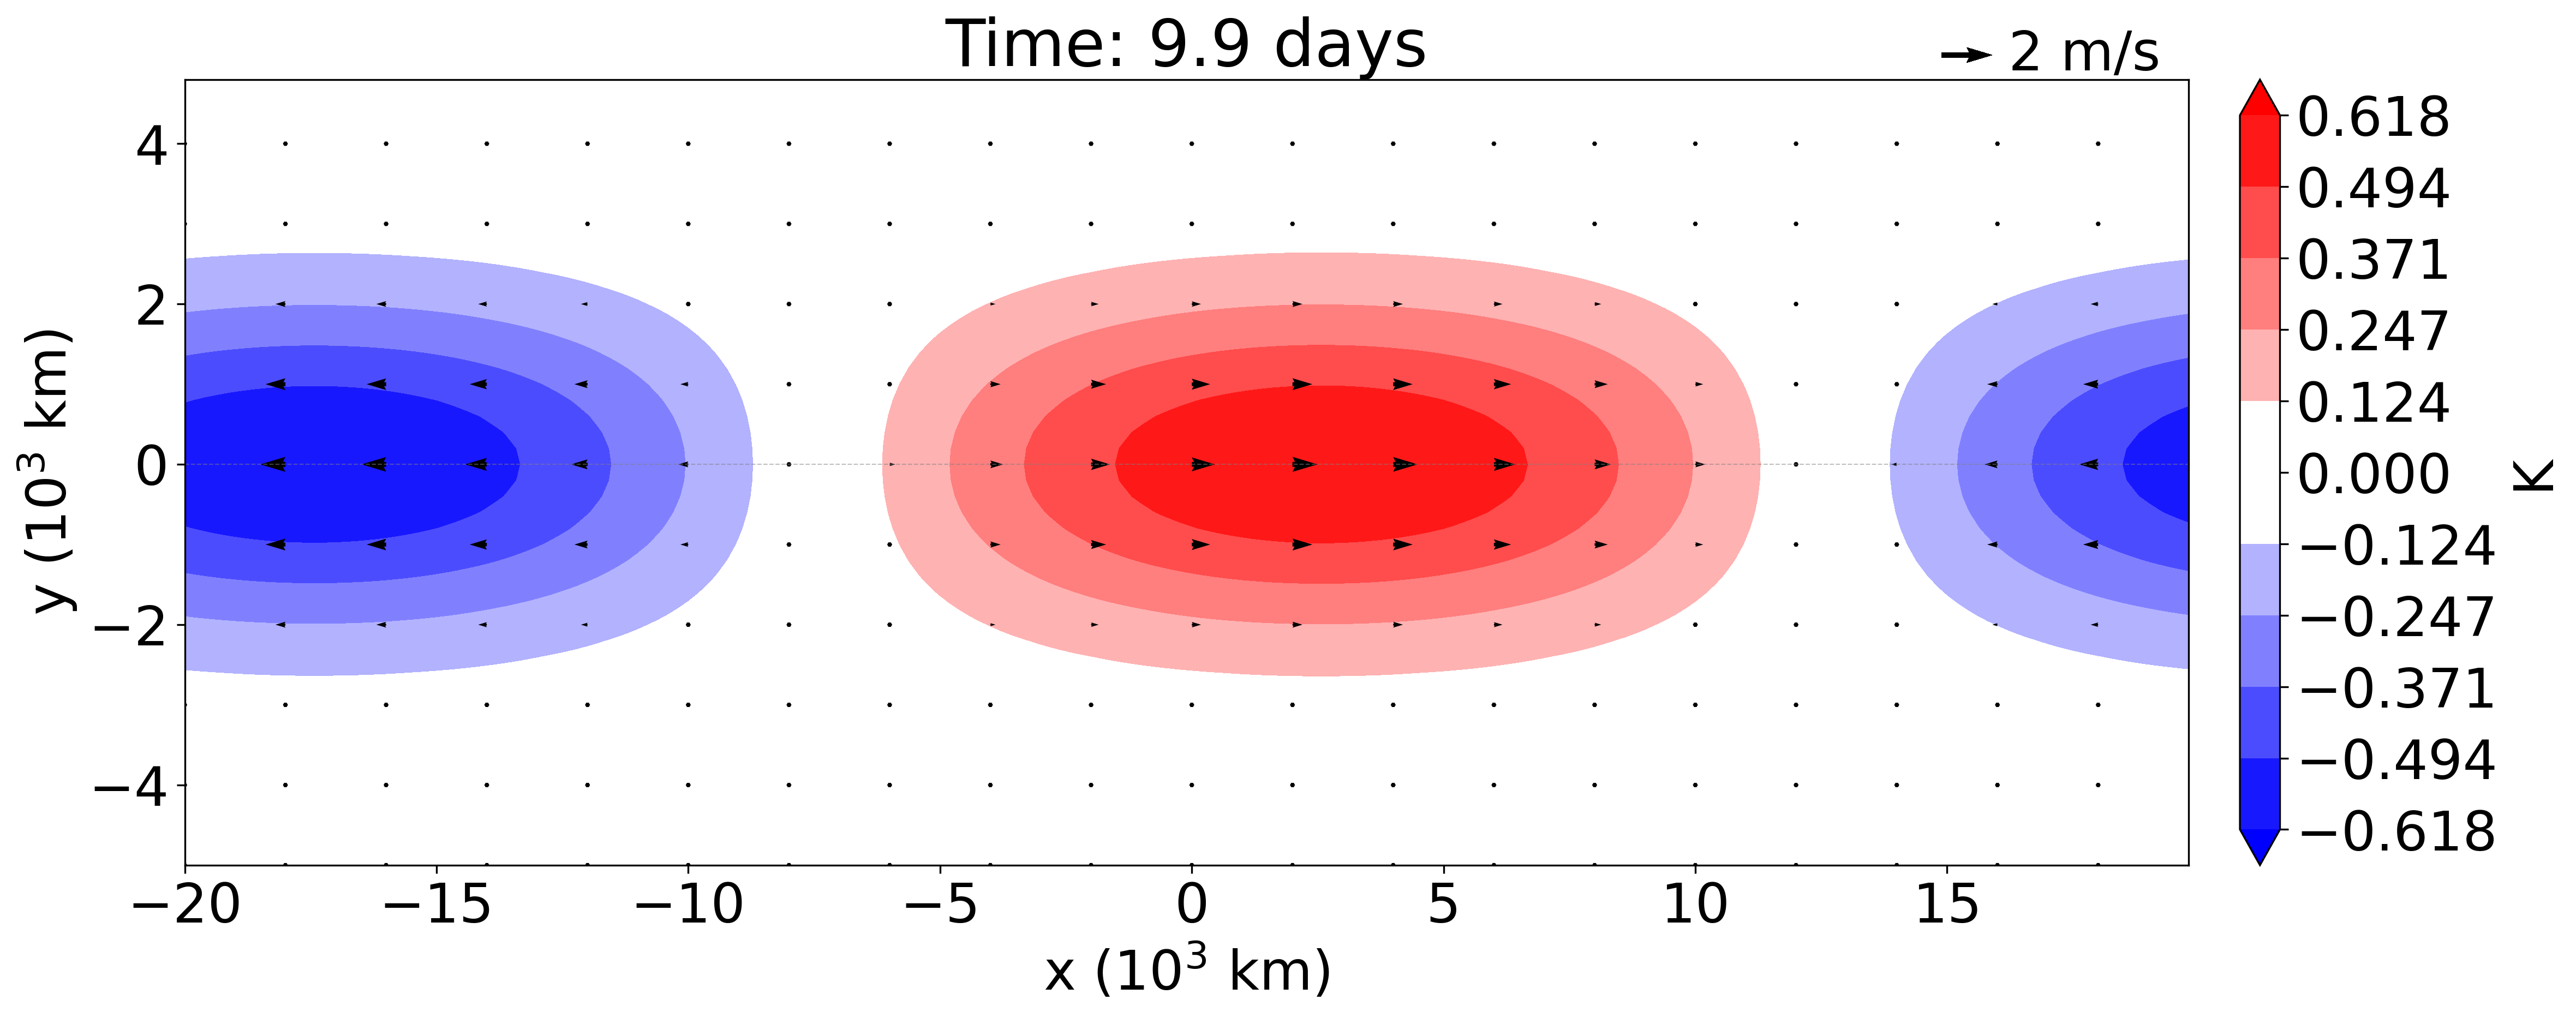

In [1088]:
# Specify plotting parameters
plt.style.use('default')
plt.rcParams.update({'font.size':24})

n_frames = 50
starting_frame = 0
frame_interval = int((nt - starting_frame)/n_frames)
frames = np.arange(starting_frame, nt, frame_interval)

quiver_scale = int(np.ceil(np.max(zonal_velocity)))
grid_scaling = 1e-6

column_integrated_mass = 1000*10/9.8 

contour_args = {
    # 'levels' : np.arange(
    #                -np.around(gravity_wave_phase_speed, 0), 
    #                np.around(gravity_wave_phase_speed, 0)+10, 
    #                10
    #            ),
    'levels' : np.linspace(np.min(column_temperature/column_integrated_mass), np.max(column_temperature/column_integrated_mass), 11),
    'norm'   : mcolors.CenteredNorm(),
    'cmap'   : modified_cmap, 
    'extend' : 'both'    
}

quiver_args = {
    'color'       : 'k',
    'width'       : 0.0025,
    'angles'      : 'xy',
    'scale_units' : 'xy',
    'scale'       : quiver_scale
}

fig = plt.figure(figsize=(16,6),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)d
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.25)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time_points[starting_frame]/SECONDS_PER_DAY:0.1f} days")

cont = ax.contourf(
    zonal_gridpoints*grid_scaling,
    meridional_gridpoints*grid_scaling,
    column_temperature[starting_frame]/column_integrated_mass,
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_label(f"K")
cbar.set_ticks(contour_args['levels'])

quiv = ax.quiver(
    zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
    meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
    zonal_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    meridional_velocity[starting_frame,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
    **quiver_args
)

ax.quiverkey(
    quiv,          
    0.79, 0.925,          
    U=quiver_scale,          
    label=f'{quiver_scale} m/s',          
    coordinates='figure', labelpos='E',          
    color='black', labelcolor='black'
)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('auto')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

def update(current_frame):
    
    # plotting_index = starting_frame + frame_interval*current_frame
    plotting_index = current_frame
    
    ax.set_title(f"Time: {time_points[plotting_index]/SECONDS_PER_DAY:0.1f} days")
    cont = ax.contourf(
        zonal_gridpoints*grid_scaling,
        meridional_gridpoints*grid_scaling,
        column_temperature[plotting_index]/column_integrated_mass,
        **contour_args
    )
    quiv = ax.quiver(
        zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
        meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
        zonal_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        meridional_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        **quiver_args
    )
    return cont, quiv
    
anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

anim_dir = r"/home/disk/eos7/sressel/Research/Code/graphics/"
anim_file_name = f"Ahmed_k={initial_wavenumber}_{initial_wave}_wave.mp4"
anim.save(anim_dir + anim_file_name, dpi=300)